In [5]:
import pandas as pd
import numpy as np
import joblib
import os

# Loại bỏ sklearn.ensemble vì LSTM không nằm ở đây
# import các thư viện cần cho LSTM từ keras/tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


In [6]:
pd.set_option('display.max_rows', None)

In [7]:
param_dist = {
    'units': [32, 64, 128],               # số neurons LSTM
    'dropout': [0.2, 0.3, 0.5],          # dropout rate
    'batch_size': [16, 32, 64],           # batch size khi train
    'epochs': [10, 20, 50],               # số epochs
    'learning_rate': [0.001, 0.0005, 0.0001],  # tốc độ học
}


In [8]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

def build_lstm_model(input_shape, num_classes, units=64, dropout=0.3):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_phase(phase_path, n_iter=10, random_state=42, sample=False, epochs=30, batch_size=32):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Reshape dữ liệu cho LSTM: (samples, timesteps=1, features)
        X_train_lstm = np.expand_dims(X_train_scaled.values, axis=1)
        X_val_lstm = np.expand_dims(X_val_scaled.values, axis=1)

        # One-hot encode label
        classes = np.unique(np.concatenate((y_train, y_val)))
        num_classes = len(classes)
        y_train_cat = to_categorical(np.searchsorted(classes, y_train), num_classes)
        y_val_cat = to_categorical(np.searchsorted(classes, y_val), num_classes)

        # Xây dựng mô hình LSTM (bạn có thể thay đổi params hoặc thêm vòng loop tuning riêng)
        model = build_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), num_classes=num_classes)

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train_lstm, y_train_cat,
            validation_data=(X_val_lstm, y_val_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=2
        )

        # Dự đoán
        y_proba = model.predict(X_val_lstm)
        y_pred = np.argmax(y_proba, axis=1)
        y_true_idx = np.searchsorted(classes, y_val)

        acc = accuracy_score(y_true_idx, y_pred)
        f1 = f1_score(y_true_idx, y_pred, average='macro')

        y_val_bin = label_binarize(y_true_idx, classes=range(num_classes))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_true_idx, y_pred))

        cm = confusion_matrix(y_true_idx, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Không có feature_importances_ với LSTM, bỏ phần đó

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========



2025-05-28 19:15:25.362386: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 5s - 14ms/step - accuracy: 0.6237 - loss: 1.0403 - val_accuracy: 0.6674 - val_loss: 0.8377
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6781 - loss: 0.8230 - val_accuracy: 0.6799 - val_loss: 0.7868
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6879 - loss: 0.7868 - val_accuracy: 0.6943 - val_loss: 0.7681
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6954 - loss: 0.7705 - val_accuracy: 0.7020 - val_loss: 0.7548
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6969 - loss: 0.7596 - val_accuracy: 0.7053 - val_loss: 0.7460
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.7011 - loss: 0.7489 - val_accuracy: 0.6976 - val_loss: 0.7445
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.7030 - loss: 0.7456 - val_accuracy: 0.7061 - val_loss: 0.7382
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.7037 - loss: 0.7328 - val_accuracy: 0.7076 - val_loss: 0.7320
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.7094 - loss: 0.7296 - val_accuracy: 0.7112 - val_loss: 0.7286


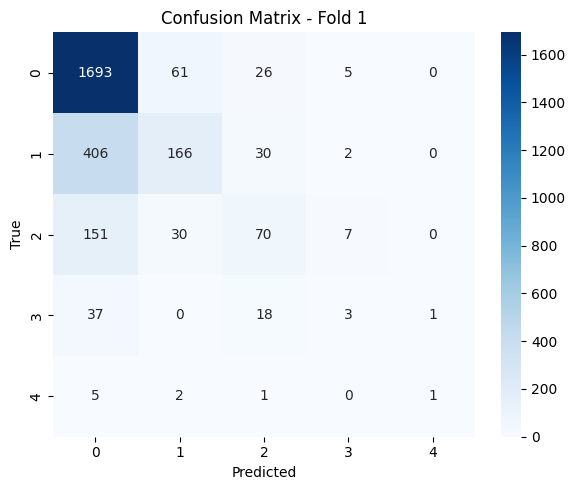

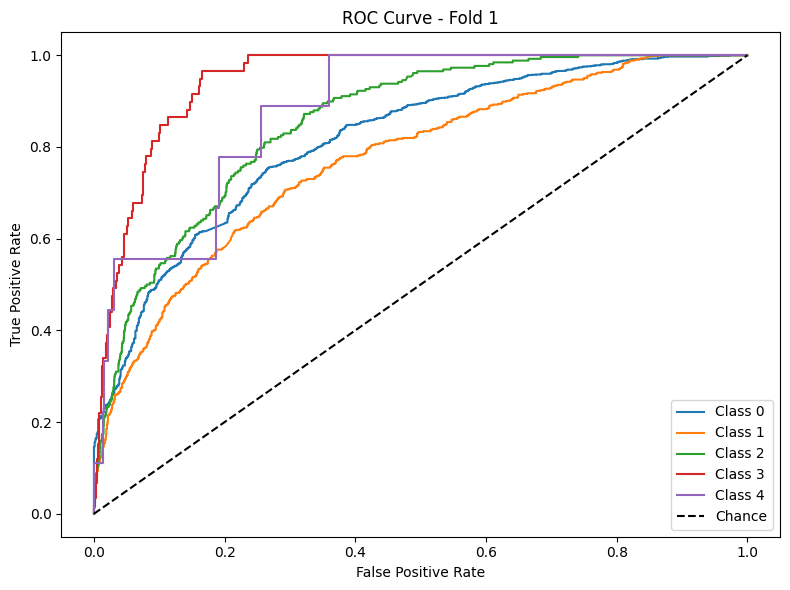

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 4s - 13ms/step - accuracy: 0.6296 - loss: 1.0382 - val_accuracy: 0.6735 - val_loss: 0.8632
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6802 - loss: 0.8139 - val_accuracy: 0.6857 - val_loss: 0.8049
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6887 - loss: 0.7784 - val_accuracy: 0.6898 - val_loss: 0.7862
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6943 - loss: 0.7594 - val_accuracy: 0.6916 - val_loss: 0.7686
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.7019 - loss: 0.7453 - val_accuracy: 0.6912 - val_loss: 0.7649
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.7055 - loss: 0.7359 - val_accuracy: 0.6979 - val_loss: 0.7517
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.7097 - loss: 0.7319 - val_accuracy: 0.6953 - val_loss: 0.7597
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.7085 - loss: 0.7286 - val_accuracy: 0.6968 - val_loss: 0.7491
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.7085 - loss: 0.7221 - val_accuracy: 0.7001 - val_loss: 0.7439
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


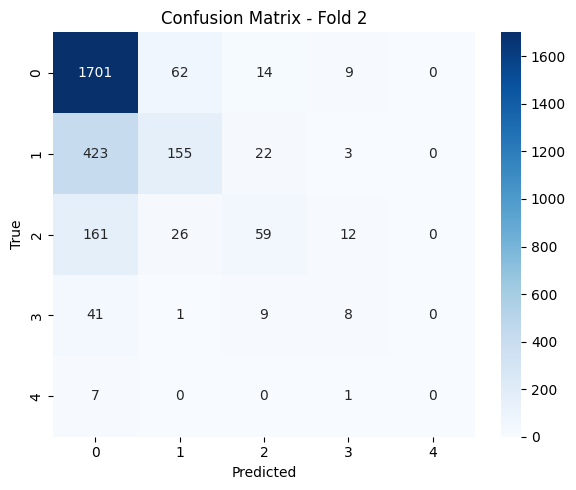

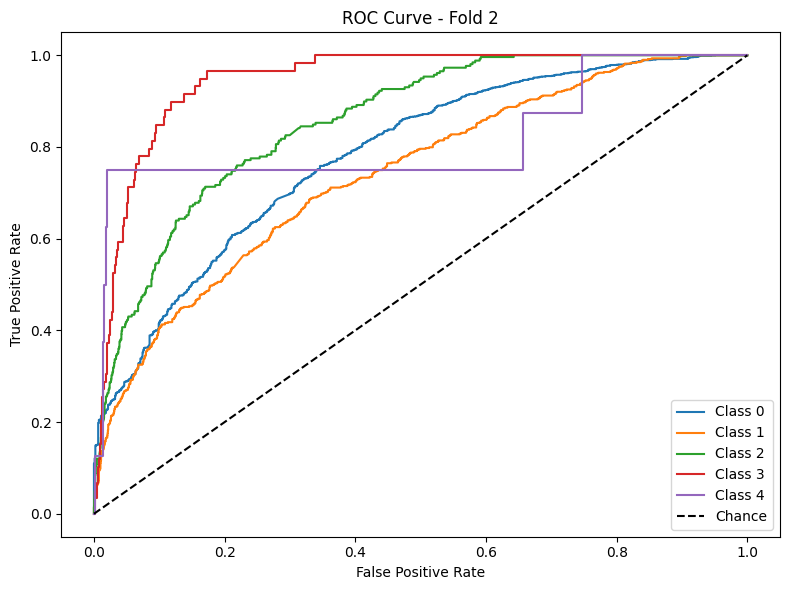

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 4s - 12ms/step - accuracy: 0.6298 - loss: 1.0265 - val_accuracy: 0.6684 - val_loss: 0.8413
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6787 - loss: 0.8180 - val_accuracy: 0.6912 - val_loss: 0.7811
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6890 - loss: 0.7809 - val_accuracy: 0.6879 - val_loss: 0.7656
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6923 - loss: 0.7668 - val_accuracy: 0.6971 - val_loss: 0.7525
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6939 - loss: 0.7538 - val_accuracy: 0.6993 - val_loss: 0.7467
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.7028 - loss: 0.7448 - val_accuracy: 0.7015 - val_loss: 0.7383
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.7053 - loss: 0.7371 - val_accuracy: 0.7049 - val_loss: 0.7283
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.7055 - loss: 0.7303 - val_accuracy: 0.7019 - val_loss: 0.7293
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.7042 - loss: 0.7292 - val_accuracy: 0.7063 - val_loss: 0.7254
Epoch 10/30

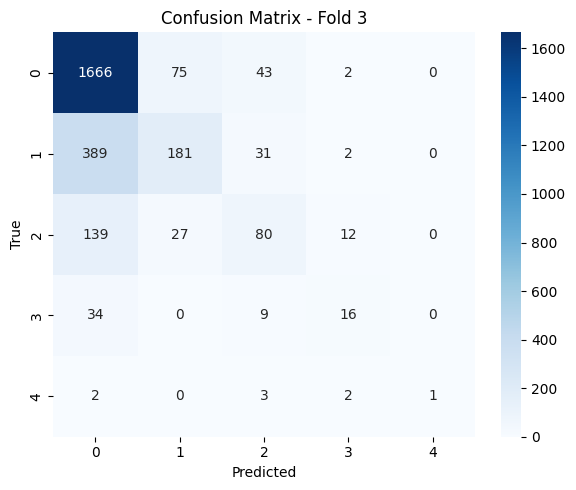

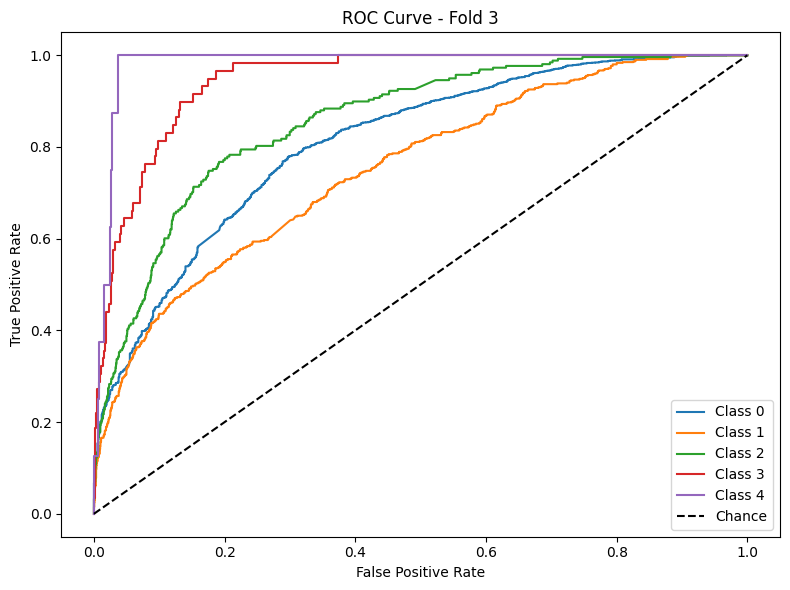

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 14ms/step - accuracy: 0.6311 - loss: 1.0485 - val_accuracy: 0.6798 - val_loss: 0.8331
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6781 - loss: 0.8239 - val_accuracy: 0.6894 - val_loss: 0.7788
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6826 - loss: 0.7918 - val_accuracy: 0.7001 - val_loss: 0.7621
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6883 - loss: 0.7749 - val_accuracy: 0.7133 - val_loss: 0.7414
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6925 - loss: 0.7633 - val_accuracy: 0.7133 - val_loss: 0.7329
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.6978 - loss: 0.7530 - val_accuracy: 0.7126 - val_loss: 0.7230
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.6988 - loss: 0.7481 - val_accuracy: 0.7144 - val_loss: 0.7183
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.6987 - loss: 0.7418 - val_accuracy: 0.7196 - val_loss: 0.7149
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.7006 - loss: 0.7342 - val_accuracy: 0.7189 - val_loss: 0.7114
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


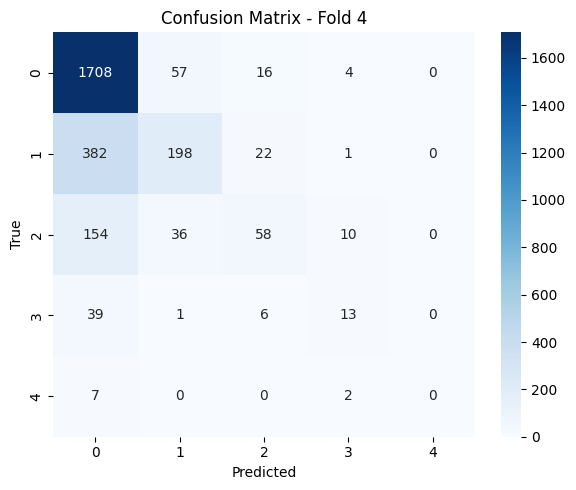

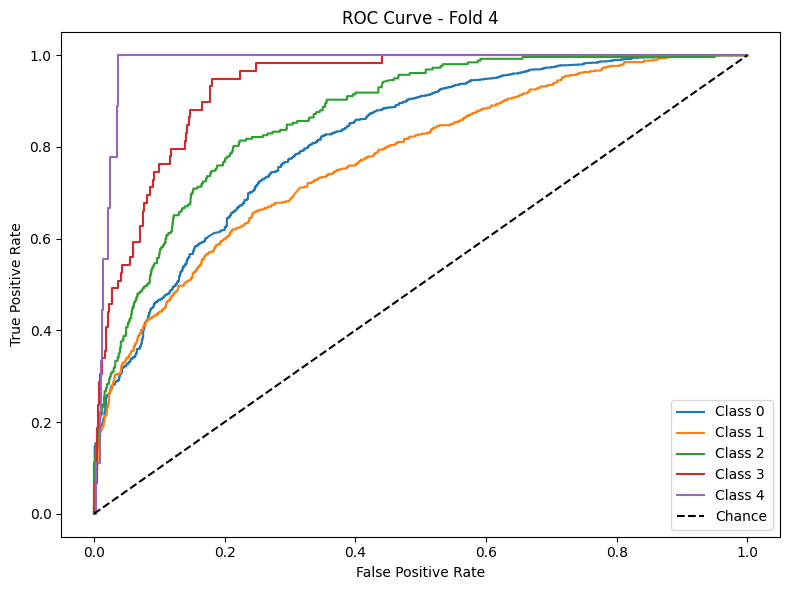

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 13ms/step - accuracy: 0.6269 - loss: 1.0332 - val_accuracy: 0.6783 - val_loss: 0.8263
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6813 - loss: 0.8158 - val_accuracy: 0.6927 - val_loss: 0.7807
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6899 - loss: 0.7824 - val_accuracy: 0.6997 - val_loss: 0.7618
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6925 - loss: 0.7673 - val_accuracy: 0.6986 - val_loss: 0.7516
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6952 - loss: 0.7575 - val_accuracy: 0.6997 - val_loss: 0.7458
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.6972 - loss: 0.7477 - val_accuracy: 0.7004 - val_loss: 0.7422
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.7029 - loss: 0.7415 - val_accuracy: 0.7063 - val_loss: 0.7335
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.7042 - loss: 0.7351 - val_accuracy: 0.6997 - val_loss: 0.7375
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.7056 - loss: 0.7279 - val_accuracy: 0.7097 - val_loss: 0.7252
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


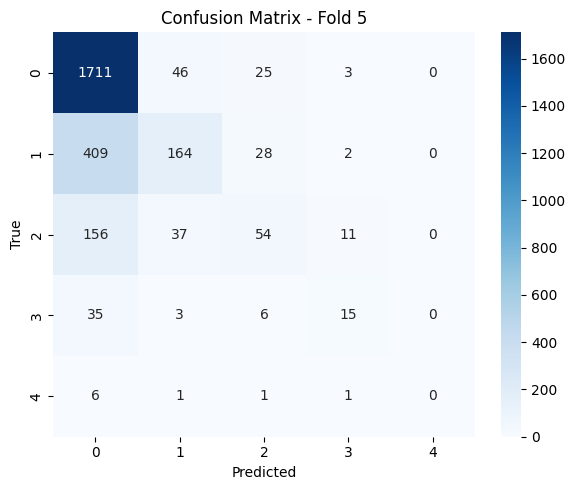

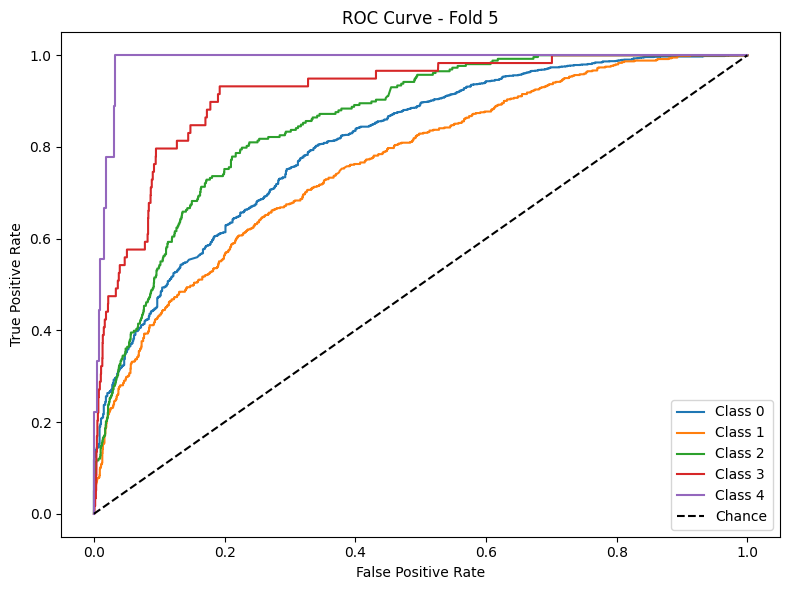


Average Accuracy: 0.7163
Average F1 Macro: 0.3772
Average AUC: 0.8581


======= Training Phase 2 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 14ms/step - accuracy: 0.6367 - loss: 1.0532 - val_accuracy: 0.6699 - val_loss: 0.8507
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6790 - loss: 0.8288 - val_accuracy: 0.6788 - val_loss: 0.7955
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6831 - loss: 0.7916 - val_accuracy: 0.6841 - val_loss: 0.7776
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6907 - loss: 0.7670 - val_accuracy: 0.6832 - val_loss: 0.7714
Epoch 5/30
283/283 - 1s - 3ms/step - accuracy: 0.6938 - loss: 0.7553 - val_accuracy: 0.6863 - val_loss: 0.7577
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6966 - loss: 0.7498 - val_accuracy: 0.6872 - val_loss: 0.7589
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6986 - loss: 0.7410 - val_accuracy: 0.6960 - val_loss: 0.7522
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6999 - loss: 0.7345 - val_accuracy: 0.6978 - val_loss: 0.7483
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.7047 - loss: 0.7280 - val_accuracy: 0.6942 - val_loss: 0.7446
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


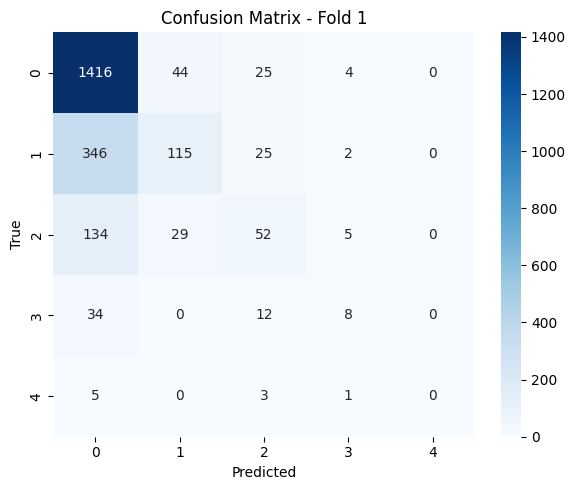

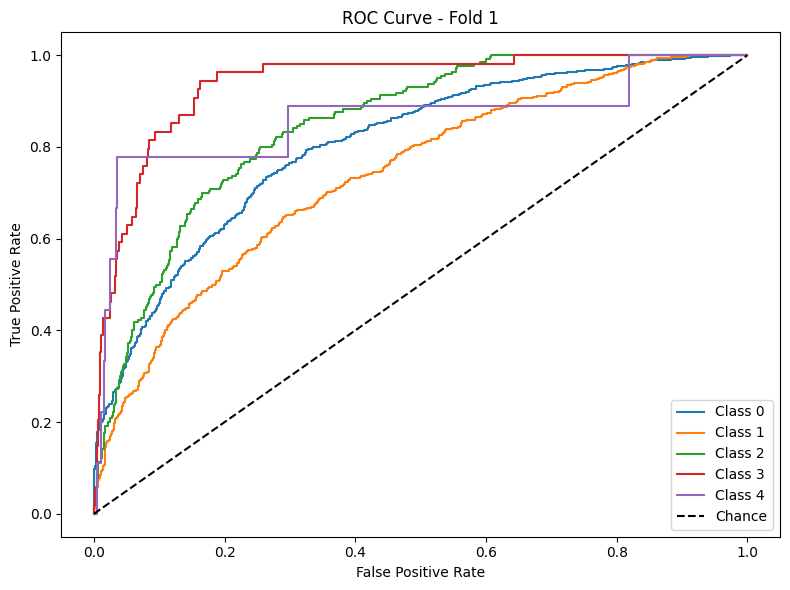

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 5s - 16ms/step - accuracy: 0.6410 - loss: 1.0436 - val_accuracy: 0.6810 - val_loss: 0.8362
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6725 - loss: 0.8222 - val_accuracy: 0.6863 - val_loss: 0.7902
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6784 - loss: 0.7885 - val_accuracy: 0.6872 - val_loss: 0.7676
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6863 - loss: 0.7690 - val_accuracy: 0.6973 - val_loss: 0.7553
Epoch 5/30
283/283 - 1s - 3ms/step - accuracy: 0.6939 - loss: 0.7594 - val_accuracy: 0.6934 - val_loss: 0.7461
Epoch 6/30
283/283 - 1s - 3ms/step - accuracy: 0.6967 - loss: 0.7440 - val_accuracy: 0.6956 - val_loss: 0.7458
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6992 - loss: 0.7397 - val_accuracy: 0.6934 - val_loss: 0.7378
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6985 - loss: 0.7312 - val_accuracy: 0.6969 - val_loss: 0.7360
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.6989 - loss: 0.7314 - val_accuracy: 0.6982 - val_loss: 0.7309
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


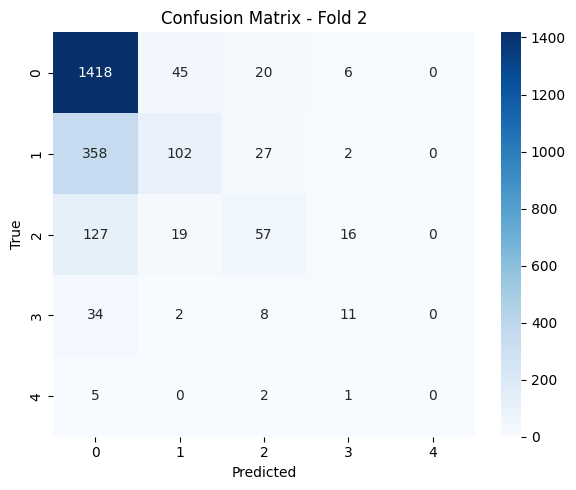

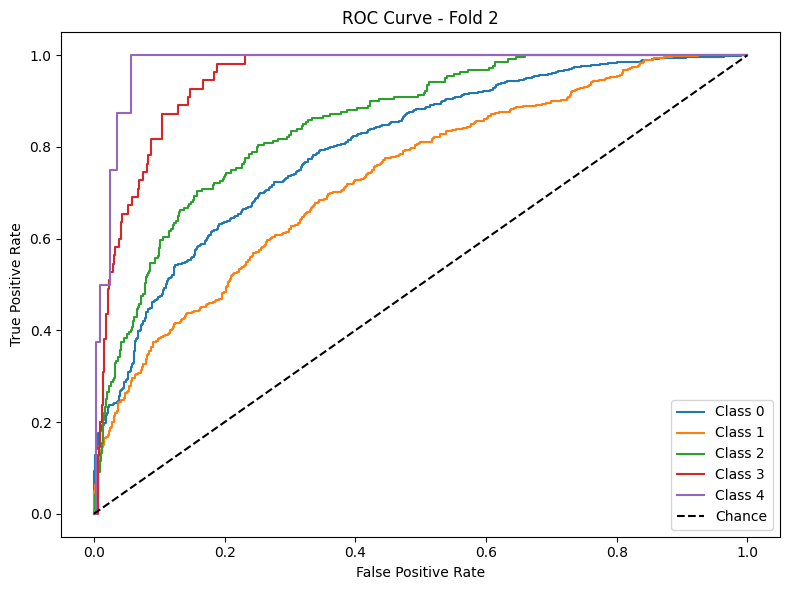

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 14ms/step - accuracy: 0.6320 - loss: 1.0584 - val_accuracy: 0.6720 - val_loss: 0.8591
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6776 - loss: 0.8198 - val_accuracy: 0.6799 - val_loss: 0.7992
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6847 - loss: 0.7835 - val_accuracy: 0.6822 - val_loss: 0.7826
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6915 - loss: 0.7618 - val_accuracy: 0.6870 - val_loss: 0.7640
Epoch 5/30
283/283 - 1s - 3ms/step - accuracy: 0.6931 - loss: 0.7544 - val_accuracy: 0.6808 - val_loss: 0.7602
Epoch 6/30
283/283 - 1s - 3ms/step - accuracy: 0.6966 - loss: 0.7432 - val_accuracy: 0.6857 - val_loss: 0.7534
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6969 - loss: 0.7401 - val_accuracy: 0.6826 - val_loss: 0.7543
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6947 - loss: 0.7332 - val_accuracy: 0.6875 - val_loss: 0.7521
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.7017 - loss: 0.7274 - val_accuracy: 0.6892 - val_loss: 0.7472
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


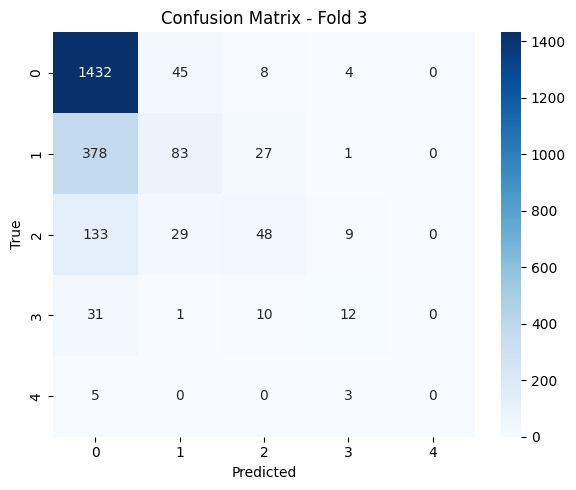

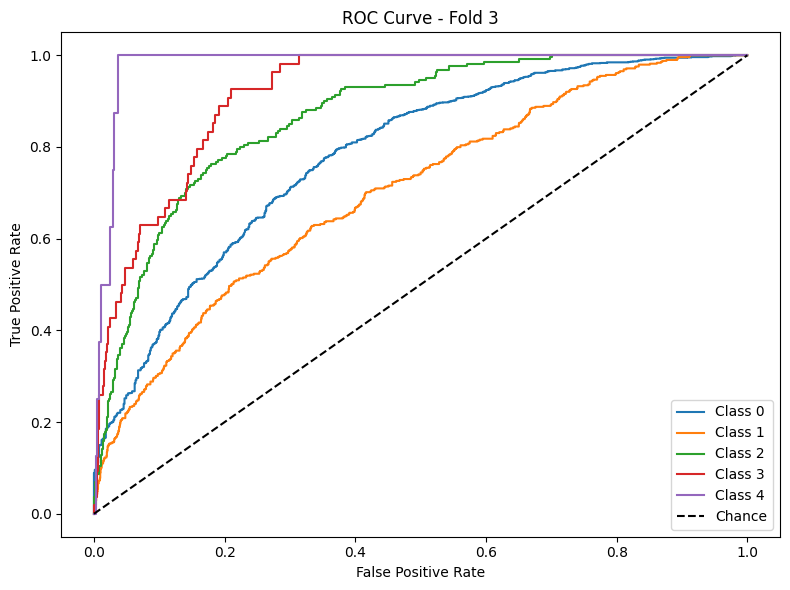

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 5s - 16ms/step - accuracy: 0.6319 - loss: 1.0612 - val_accuracy: 0.6777 - val_loss: 0.8543
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6760 - loss: 0.8249 - val_accuracy: 0.6830 - val_loss: 0.7987
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6871 - loss: 0.7886 - val_accuracy: 0.6879 - val_loss: 0.7801
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6899 - loss: 0.7679 - val_accuracy: 0.6901 - val_loss: 0.7622
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6943 - loss: 0.7533 - val_accuracy: 0.6915 - val_loss: 0.7535
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6956 - loss: 0.7448 - val_accuracy: 0.6954 - val_loss: 0.7496
Epoch 7/30
283/283 - 1s - 4ms/step - accuracy: 0.6983 - loss: 0.7368 - val_accuracy: 0.6977 - val_loss: 0.7440
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6998 - loss: 0.7316 - val_accuracy: 0.6985 - val_loss: 0.7425
Epoch 9/30
283/283 - 1s - 4ms/step - accuracy: 0.7009 - loss: 0.7289 - val_accuracy: 0.6941 - val_loss: 0.7328
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


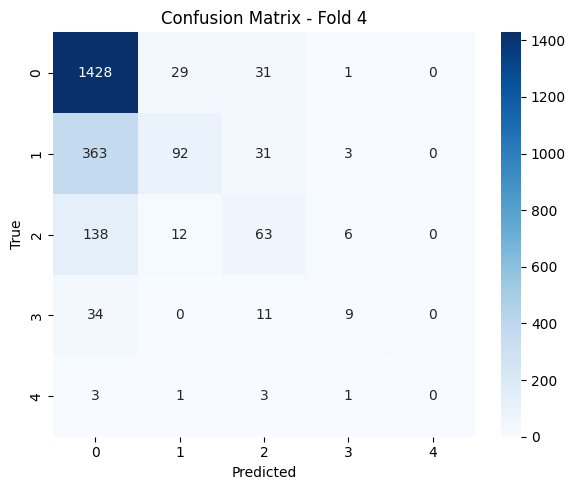

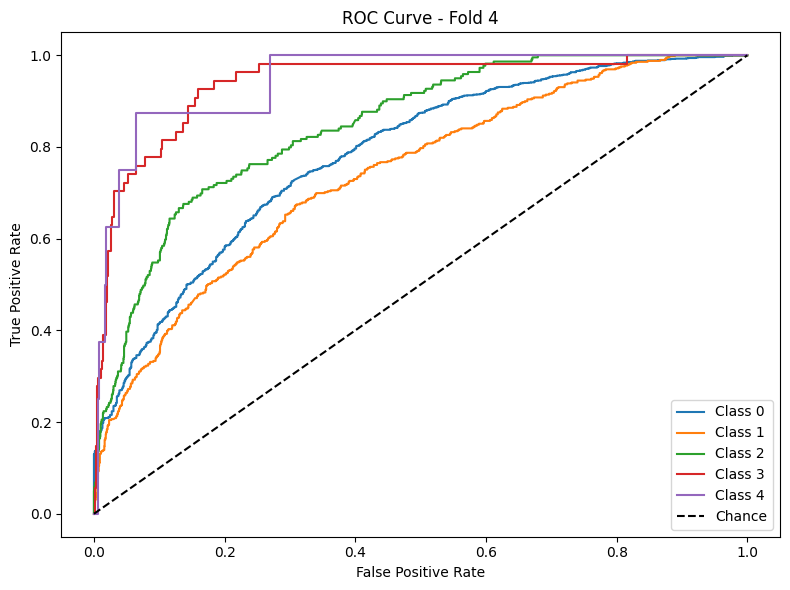

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 15ms/step - accuracy: 0.6267 - loss: 1.0764 - val_accuracy: 0.6742 - val_loss: 0.8384
Epoch 2/30
283/283 - 1s - 4ms/step - accuracy: 0.6733 - loss: 0.8244 - val_accuracy: 0.6799 - val_loss: 0.7828
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6862 - loss: 0.7846 - val_accuracy: 0.6928 - val_loss: 0.7627
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6822 - loss: 0.7694 - val_accuracy: 0.6941 - val_loss: 0.7575
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6917 - loss: 0.7563 - val_accuracy: 0.6932 - val_loss: 0.7507
Epoch 6/30
283/283 - 1s - 3ms/step - accuracy: 0.6917 - loss: 0.7477 - val_accuracy: 0.6968 - val_loss: 0.7440
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6967 - loss: 0.7448 - val_accuracy: 0.7034 - val_loss: 0.7371
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.7009 - loss: 0.7328 - val_accuracy: 0.7043 - val_loss: 0.7391
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.7031 - loss: 0.7278 - val_accuracy: 0.7039 - val_loss: 0.7263
Epoch 10/30

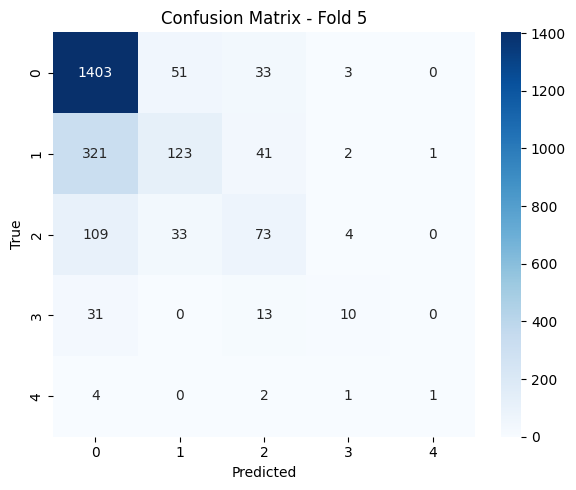

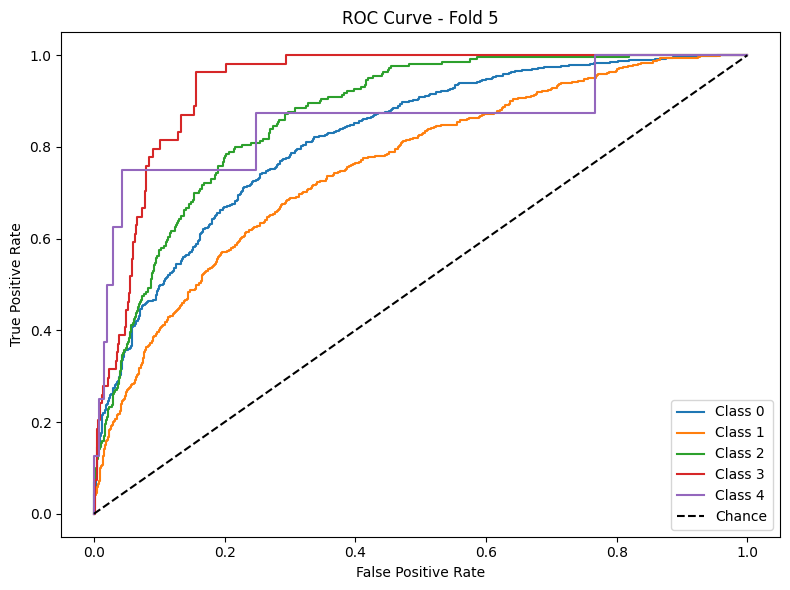


Average Accuracy: 0.7043
Average F1 Macro: 0.3541
Average AUC: 0.8501


======= Training Phase 3 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 5s - 18ms/step - accuracy: 0.6329 - loss: 1.0881 - val_accuracy: 0.6837 - val_loss: 0.8575
Epoch 2/30
260/260 - 1s - 3ms/step - accuracy: 0.6784 - loss: 0.8344 - val_accuracy: 0.6837 - val_loss: 0.7881
Epoch 3/30
260/260 - 1s - 3ms/step - accuracy: 0.6845 - loss: 0.7892 - val_accuracy: 0.6905 - val_loss: 0.7669
Epoch 4/30
260/260 - 1s - 3ms/step - accuracy: 0.6898 - loss: 0.7681 - val_accuracy: 0.6958 - val_loss: 0.7499
Epoch 5/30
260/260 - 1s - 3ms/step - accuracy: 0.6903 - loss: 0.7582 - val_accuracy: 0.6977 - val_loss: 0.7449
Epoch 6/30
260/260 - 1s - 3ms/step - accuracy: 0.6987 - loss: 0.7444 - val_accuracy: 0.7001 - val_loss: 0.7385
Epoch 7/30
260/260 - 1s - 3ms/step - accuracy: 0.6991 - loss: 0.7387 - val_accuracy: 0.6972 - val_loss: 0.7350
Epoch 8/30
260/260 - 1s - 3ms/step - accuracy: 0.7020 - loss: 0.7290 - val_accuracy: 0.7035 - val_loss: 0.7283
Epoch 9/30
260/260 - 1s - 3ms/step - accuracy: 0.7039 - loss: 0.7224 - val_accuracy: 0.7020 - val_loss: 0.7276
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


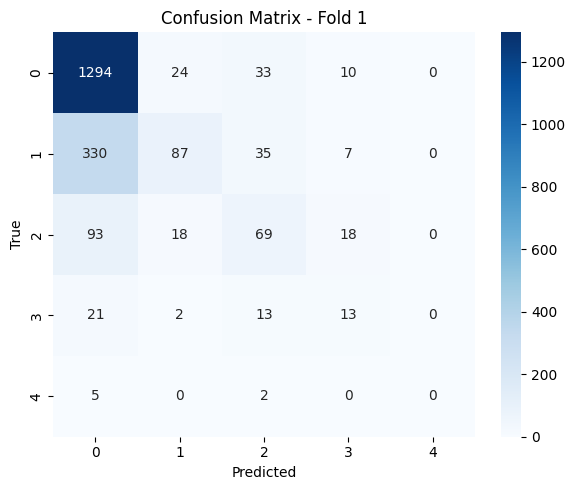

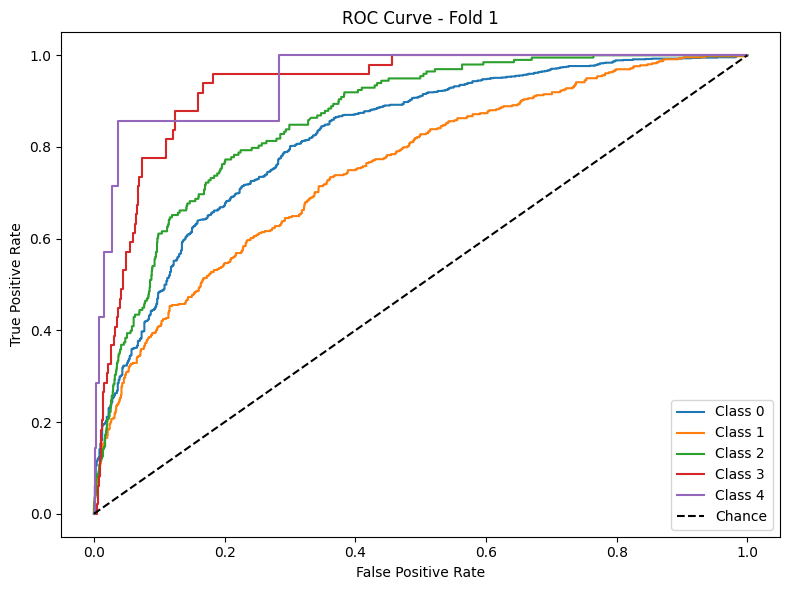

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 15ms/step - accuracy: 0.6178 - loss: 1.0991 - val_accuracy: 0.6644 - val_loss: 0.8601
Epoch 2/30
260/260 - 1s - 3ms/step - accuracy: 0.6735 - loss: 0.8382 - val_accuracy: 0.6750 - val_loss: 0.7980
Epoch 3/30
260/260 - 1s - 3ms/step - accuracy: 0.6854 - loss: 0.7915 - val_accuracy: 0.6890 - val_loss: 0.7695
Epoch 4/30
260/260 - 1s - 3ms/step - accuracy: 0.6860 - loss: 0.7663 - val_accuracy: 0.6924 - val_loss: 0.7538
Epoch 5/30
260/260 - 1s - 3ms/step - accuracy: 0.6911 - loss: 0.7502 - val_accuracy: 0.7025 - val_loss: 0.7399
Epoch 6/30
260/260 - 1s - 3ms/step - accuracy: 0.6933 - loss: 0.7454 - val_accuracy: 0.7059 - val_loss: 0.7394
Epoch 7/30
260/260 - 1s - 3ms/step - accuracy: 0.6987 - loss: 0.7352 - val_accuracy: 0.7088 - val_loss: 0.7332
Epoch 8/30
260/260 - 1s - 3ms/step - accuracy: 0.6983 - loss: 0.7276 - val_accuracy: 0.7049 - val_loss: 0.7307
Epoch 9/30
260/260 - 1s - 3ms/step - accuracy: 0.6984 - loss: 0.7205 - val_accuracy: 0.7126 - val_loss: 0.7239
Epoch 10/30

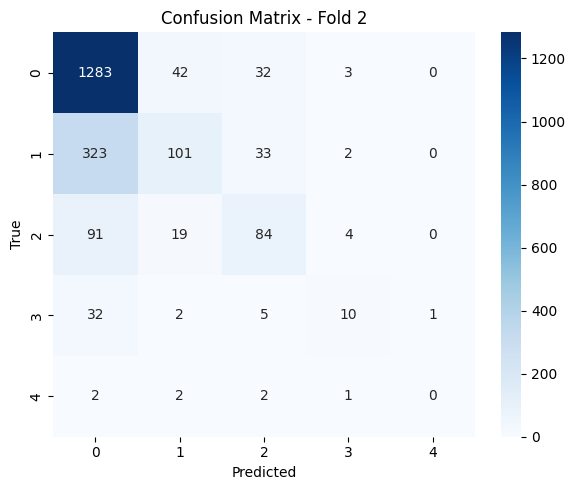

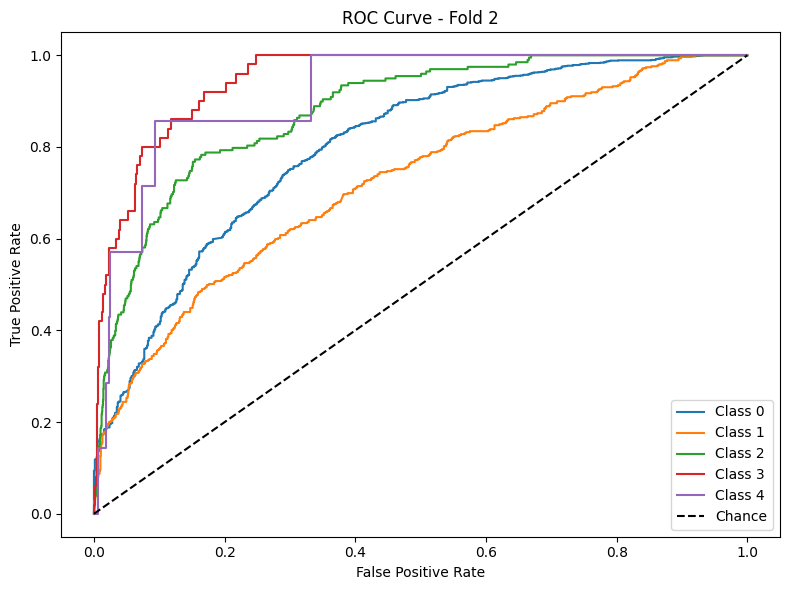

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 17ms/step - accuracy: 0.6162 - loss: 1.0829 - val_accuracy: 0.6823 - val_loss: 0.8553
Epoch 2/30
260/260 - 1s - 3ms/step - accuracy: 0.6772 - loss: 0.8301 - val_accuracy: 0.6938 - val_loss: 0.7927
Epoch 3/30
260/260 - 1s - 3ms/step - accuracy: 0.6828 - loss: 0.7904 - val_accuracy: 0.6977 - val_loss: 0.7722
Epoch 4/30
260/260 - 1s - 3ms/step - accuracy: 0.6931 - loss: 0.7652 - val_accuracy: 0.6996 - val_loss: 0.7601
Epoch 5/30
260/260 - 1s - 3ms/step - accuracy: 0.6967 - loss: 0.7499 - val_accuracy: 0.6958 - val_loss: 0.7526
Epoch 6/30
260/260 - 1s - 3ms/step - accuracy: 0.6975 - loss: 0.7418 - val_accuracy: 0.7011 - val_loss: 0.7426
Epoch 7/30
260/260 - 1s - 3ms/step - accuracy: 0.7008 - loss: 0.7338 - val_accuracy: 0.7064 - val_loss: 0.7391
Epoch 8/30
260/260 - 1s - 3ms/step - accuracy: 0.7052 - loss: 0.7247 - val_accuracy: 0.7049 - val_loss: 0.7343
Epoch 9/30
260/260 - 1s - 3ms/step - accuracy: 0.7075 - loss: 0.7196 - val_accuracy: 0.7054 - val_loss: 0.7310
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


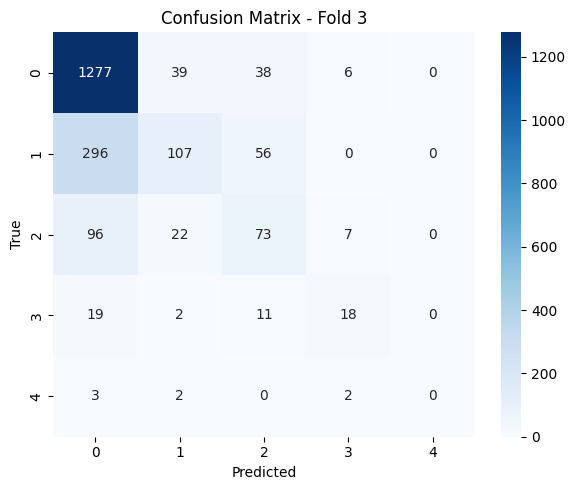

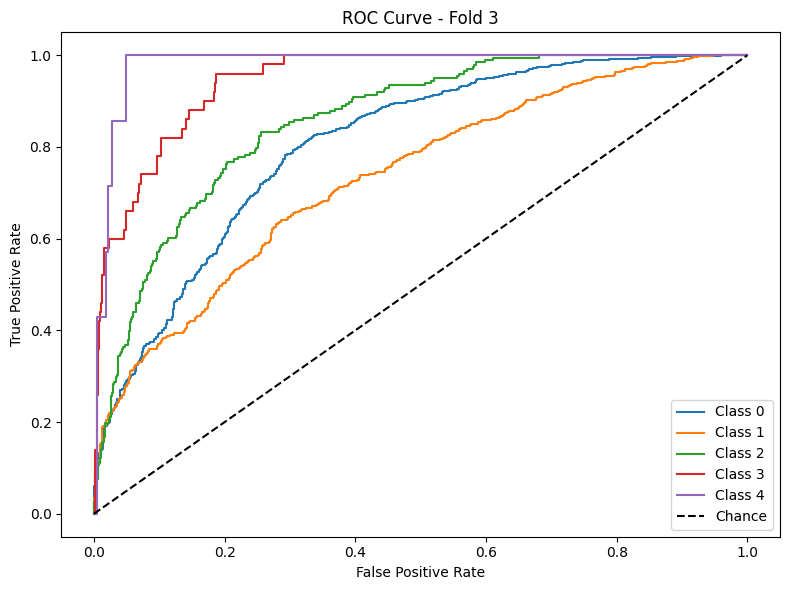

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 15ms/step - accuracy: 0.6306 - loss: 1.0723 - val_accuracy: 0.6726 - val_loss: 0.8786
Epoch 2/30
260/260 - 1s - 3ms/step - accuracy: 0.6787 - loss: 0.8276 - val_accuracy: 0.6755 - val_loss: 0.8084
Epoch 3/30
260/260 - 1s - 3ms/step - accuracy: 0.6870 - loss: 0.7813 - val_accuracy: 0.6813 - val_loss: 0.7864
Epoch 4/30
260/260 - 1s - 3ms/step - accuracy: 0.6916 - loss: 0.7645 - val_accuracy: 0.6861 - val_loss: 0.7779
Epoch 5/30
260/260 - 1s - 3ms/step - accuracy: 0.6932 - loss: 0.7527 - val_accuracy: 0.6929 - val_loss: 0.7676
Epoch 6/30
260/260 - 1s - 3ms/step - accuracy: 0.7031 - loss: 0.7366 - val_accuracy: 0.6938 - val_loss: 0.7585
Epoch 7/30
260/260 - 1s - 3ms/step - accuracy: 0.6979 - loss: 0.7302 - val_accuracy: 0.6943 - val_loss: 0.7549
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.7038 - loss: 0.7227 - val_accuracy: 0.6919 - val_loss: 0.7497
Epoch 9/30
260/260 - 1s - 3ms/step - accuracy: 0.7050 - loss: 0.7171 - val_accuracy: 0.7054 - val_loss: 0.7459
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


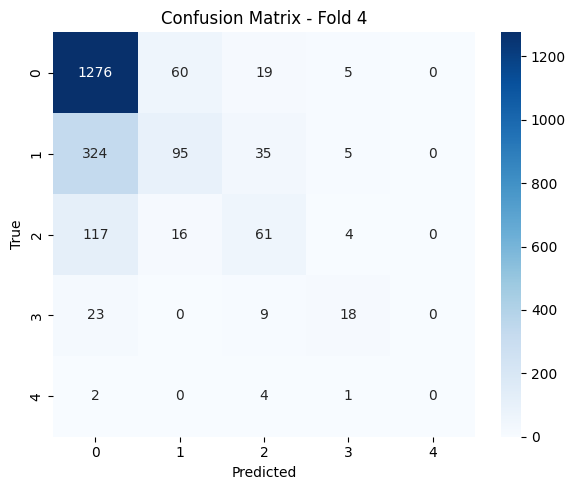

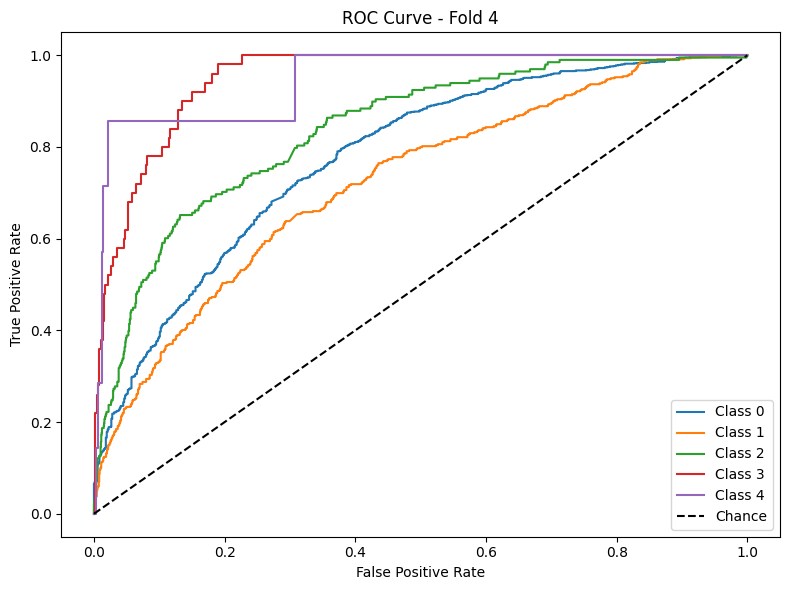

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 15ms/step - accuracy: 0.6383 - loss: 1.0734 - val_accuracy: 0.6715 - val_loss: 0.8630
Epoch 2/30
260/260 - 1s - 3ms/step - accuracy: 0.6762 - loss: 0.8316 - val_accuracy: 0.6787 - val_loss: 0.8077
Epoch 3/30
260/260 - 1s - 3ms/step - accuracy: 0.6853 - loss: 0.7889 - val_accuracy: 0.6831 - val_loss: 0.7844
Epoch 4/30
260/260 - 1s - 3ms/step - accuracy: 0.6980 - loss: 0.7612 - val_accuracy: 0.6869 - val_loss: 0.7700
Epoch 5/30
260/260 - 1s - 3ms/step - accuracy: 0.6995 - loss: 0.7496 - val_accuracy: 0.6898 - val_loss: 0.7727
Epoch 6/30
260/260 - 1s - 3ms/step - accuracy: 0.7070 - loss: 0.7348 - val_accuracy: 0.6893 - val_loss: 0.7613
Epoch 7/30
260/260 - 1s - 3ms/step - accuracy: 0.7066 - loss: 0.7270 - val_accuracy: 0.6903 - val_loss: 0.7569
Epoch 8/30
260/260 - 1s - 3ms/step - accuracy: 0.7048 - loss: 0.7245 - val_accuracy: 0.6918 - val_loss: 0.7574
Epoch 9/30
260/260 - 1s - 3ms/step - accuracy: 0.7061 - loss: 0.7166 - val_accuracy: 0.6889 - val_loss: 0.7529
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


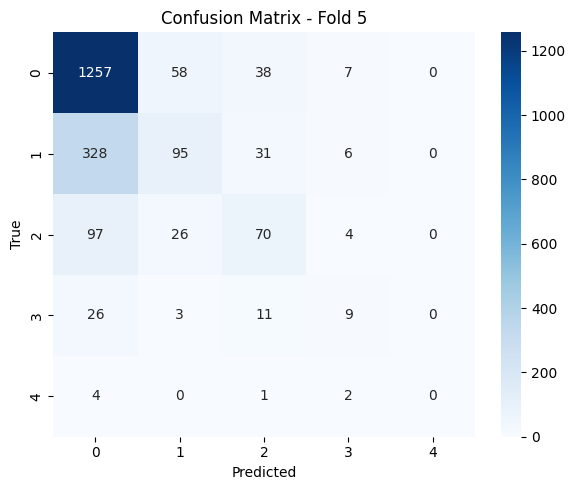

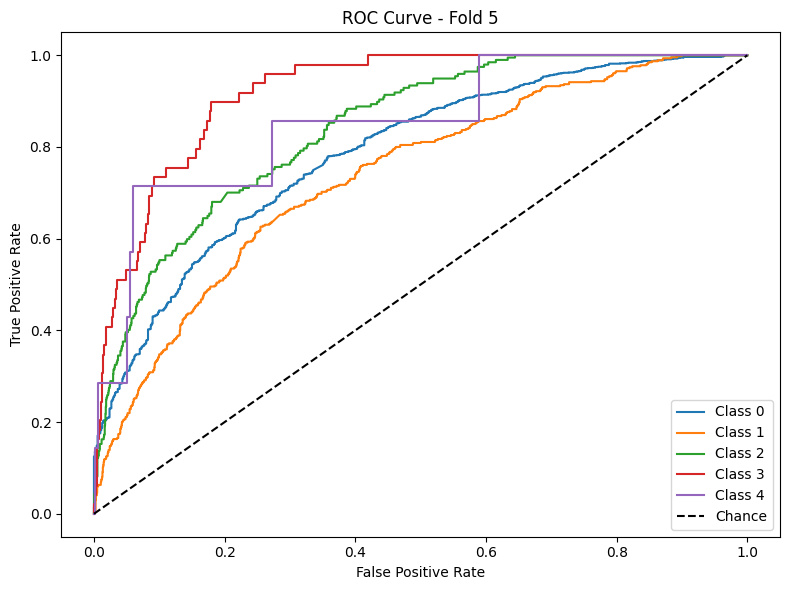


Average Accuracy: 0.7037
Average F1 Macro: 0.3754
Average AUC: 0.8510


======= Training Phase 4 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 23ms/step - accuracy: 0.6071 - loss: 1.1312 - val_accuracy: 0.6641 - val_loss: 0.9039
Epoch 2/30
193/193 - 1s - 3ms/step - accuracy: 0.6709 - loss: 0.8514 - val_accuracy: 0.6680 - val_loss: 0.8246
Epoch 3/30
193/193 - 1s - 3ms/step - accuracy: 0.6852 - loss: 0.7934 - val_accuracy: 0.6725 - val_loss: 0.7954
Epoch 4/30
193/193 - 1s - 3ms/step - accuracy: 0.6874 - loss: 0.7667 - val_accuracy: 0.6732 - val_loss: 0.7805
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.7004 - loss: 0.7421 - val_accuracy: 0.6803 - val_loss: 0.7705
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.7056 - loss: 0.7322 - val_accuracy: 0.6829 - val_loss: 0.7640
Epoch 7/30
193/193 - 1s - 3ms/step - accuracy: 0.7111 - loss: 0.7178 - val_accuracy: 0.6894 - val_loss: 0.7507
Epoch 8/30
193/193 - 1s - 3ms/step - accuracy: 0.7142 - loss: 0.7104 - val_accuracy: 0.6907 - val_loss: 0.7478
Epoch 9/30
193/193 - 1s - 3ms/step - accuracy: 0.7148 - loss: 0.7053 - val_accuracy: 0.6836 - val_loss: 0.7459
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


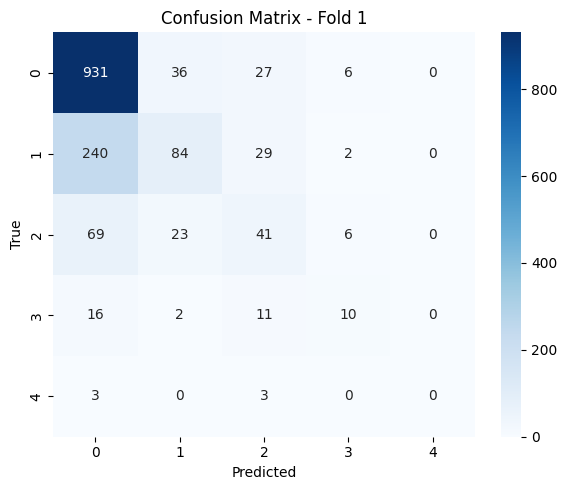

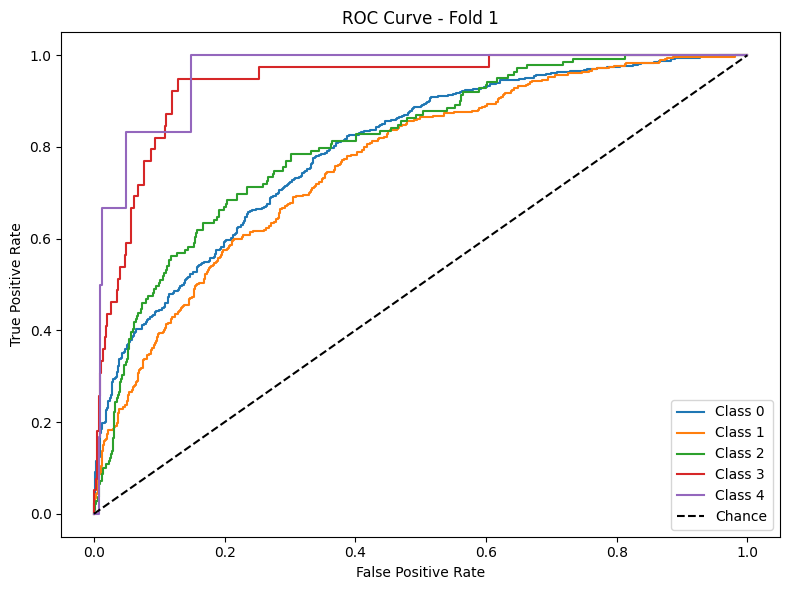

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 19ms/step - accuracy: 0.6004 - loss: 1.1460 - val_accuracy: 0.6686 - val_loss: 0.8975
Epoch 2/30
193/193 - 1s - 3ms/step - accuracy: 0.6705 - loss: 0.8522 - val_accuracy: 0.6784 - val_loss: 0.8133
Epoch 3/30
193/193 - 1s - 3ms/step - accuracy: 0.6774 - loss: 0.7971 - val_accuracy: 0.6855 - val_loss: 0.7815
Epoch 4/30
193/193 - 1s - 3ms/step - accuracy: 0.6880 - loss: 0.7684 - val_accuracy: 0.6881 - val_loss: 0.7605
Epoch 5/30
193/193 - 1s - 3ms/step - accuracy: 0.6875 - loss: 0.7508 - val_accuracy: 0.6933 - val_loss: 0.7526
Epoch 6/30
193/193 - 1s - 3ms/step - accuracy: 0.6960 - loss: 0.7380 - val_accuracy: 0.7018 - val_loss: 0.7469
Epoch 7/30
193/193 - 1s - 3ms/step - accuracy: 0.7056 - loss: 0.7240 - val_accuracy: 0.7005 - val_loss: 0.7380
Epoch 8/30
193/193 - 1s - 3ms/step - accuracy: 0.7078 - loss: 0.7134 - val_accuracy: 0.7018 - val_loss: 0.7377
Epoch 9/30
193/193 - 1s - 3ms/step - accuracy: 0.7142 - loss: 0.7105 - val_accuracy: 0.7057 - val_loss: 0.7296
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


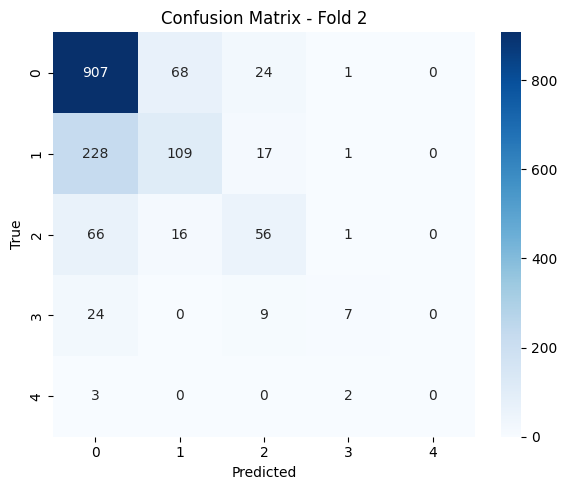

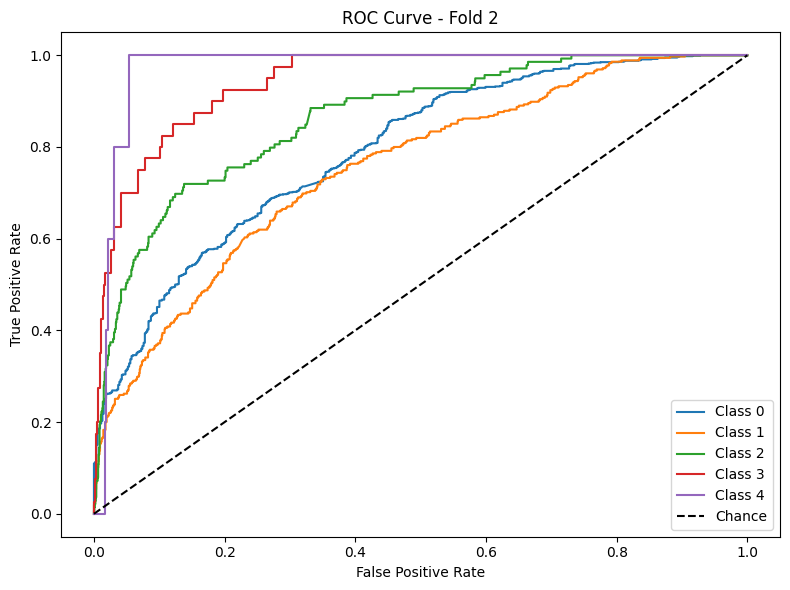

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 23ms/step - accuracy: 0.6014 - loss: 1.1529 - val_accuracy: 0.6608 - val_loss: 0.9148
Epoch 2/30
193/193 - 1s - 3ms/step - accuracy: 0.6708 - loss: 0.8540 - val_accuracy: 0.6654 - val_loss: 0.8328
Epoch 3/30
193/193 - 1s - 3ms/step - accuracy: 0.6763 - loss: 0.8001 - val_accuracy: 0.6719 - val_loss: 0.8068
Epoch 4/30
193/193 - 1s - 3ms/step - accuracy: 0.6864 - loss: 0.7703 - val_accuracy: 0.6764 - val_loss: 0.7847
Epoch 5/30
193/193 - 1s - 3ms/step - accuracy: 0.6916 - loss: 0.7516 - val_accuracy: 0.6868 - val_loss: 0.7738
Epoch 6/30
193/193 - 1s - 3ms/step - accuracy: 0.6986 - loss: 0.7390 - val_accuracy: 0.6920 - val_loss: 0.7637
Epoch 7/30
193/193 - 1s - 3ms/step - accuracy: 0.7023 - loss: 0.7277 - val_accuracy: 0.6875 - val_loss: 0.7557
Epoch 8/30
193/193 - 1s - 3ms/step - accuracy: 0.7096 - loss: 0.7150 - val_accuracy: 0.6927 - val_loss: 0.7477
Epoch 9/30
193/193 - 1s - 3ms/step - accuracy: 0.7112 - loss: 0.7059 - val_accuracy: 0.6868 - val_loss: 0.7452
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


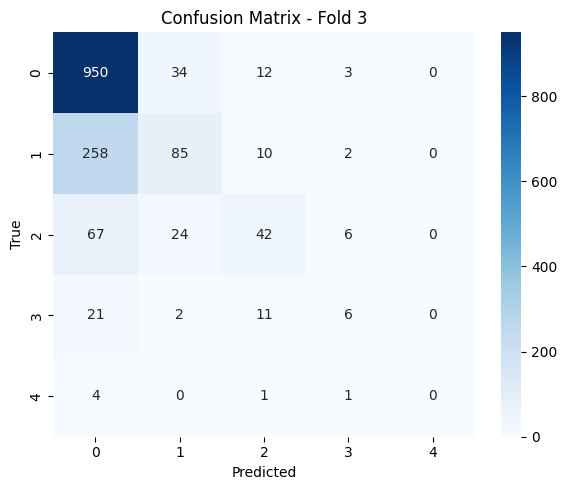

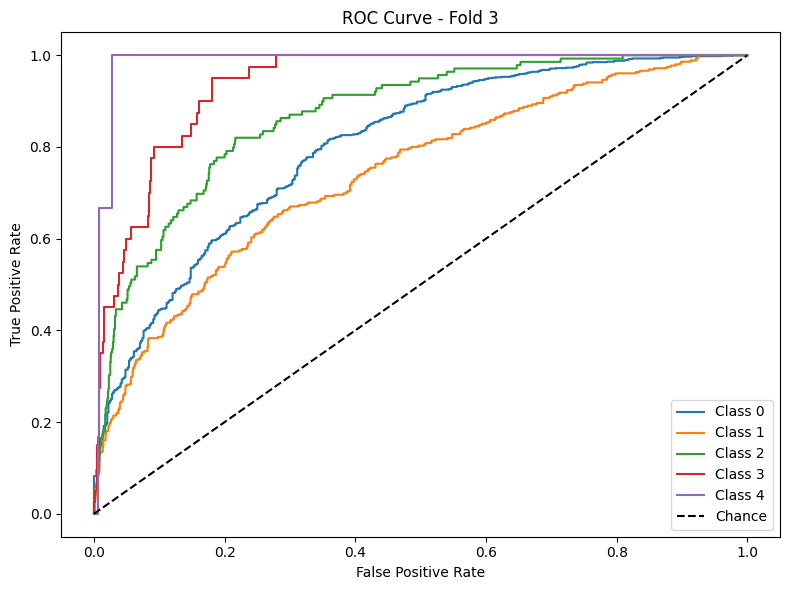

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 18ms/step - accuracy: 0.6021 - loss: 1.1495 - val_accuracy: 0.6645 - val_loss: 0.9009
Epoch 2/30
193/193 - 1s - 3ms/step - accuracy: 0.6622 - loss: 0.8566 - val_accuracy: 0.6723 - val_loss: 0.8252
Epoch 3/30
193/193 - 1s - 3ms/step - accuracy: 0.6751 - loss: 0.8063 - val_accuracy: 0.6795 - val_loss: 0.7928
Epoch 4/30
193/193 - 1s - 3ms/step - accuracy: 0.6868 - loss: 0.7722 - val_accuracy: 0.6866 - val_loss: 0.7756
Epoch 5/30
193/193 - 1s - 3ms/step - accuracy: 0.6887 - loss: 0.7524 - val_accuracy: 0.6879 - val_loss: 0.7699
Epoch 6/30
193/193 - 1s - 3ms/step - accuracy: 0.6957 - loss: 0.7398 - val_accuracy: 0.7003 - val_loss: 0.7517
Epoch 7/30
193/193 - 1s - 3ms/step - accuracy: 0.7040 - loss: 0.7277 - val_accuracy: 0.6938 - val_loss: 0.7568
Epoch 8/30
193/193 - 1s - 3ms/step - accuracy: 0.7015 - loss: 0.7189 - val_accuracy: 0.6957 - val_loss: 0.7516
Epoch 9/30
193/193 - 1s - 3ms/step - accuracy: 0.7054 - loss: 0.7163 - val_accuracy: 0.6912 - val_loss: 0.7447
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


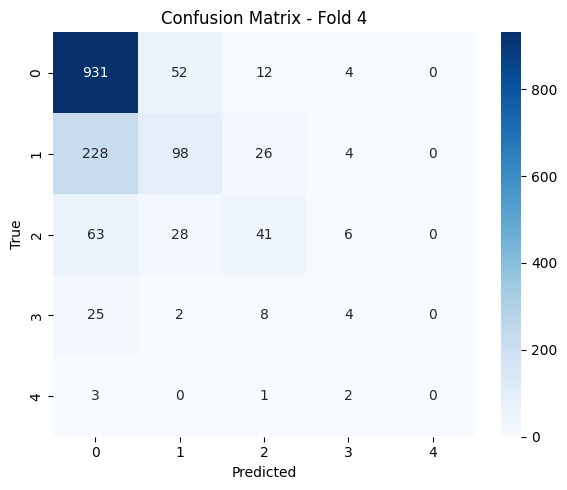

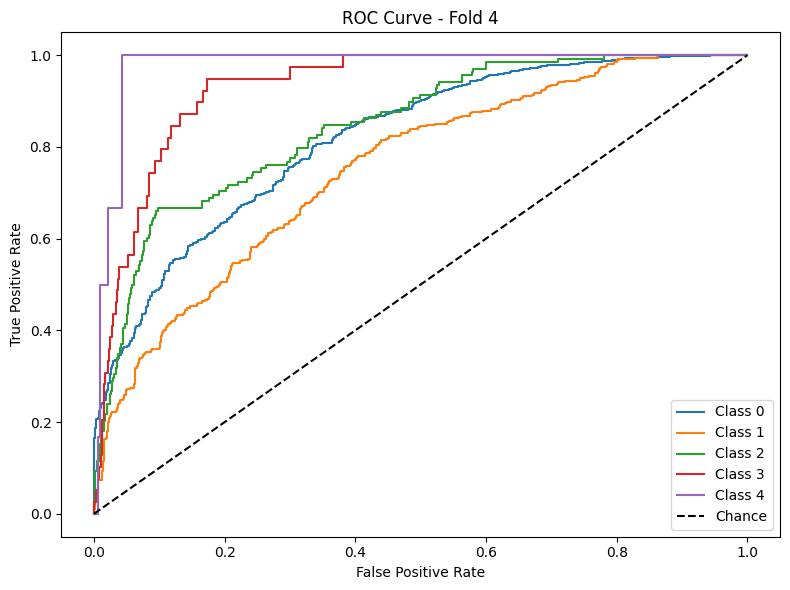

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 19ms/step - accuracy: 0.6175 - loss: 1.1214 - val_accuracy: 0.6612 - val_loss: 0.8852
Epoch 2/30
193/193 - 1s - 3ms/step - accuracy: 0.6681 - loss: 0.8630 - val_accuracy: 0.6723 - val_loss: 0.8002
Epoch 3/30
193/193 - 1s - 3ms/step - accuracy: 0.6764 - loss: 0.8086 - val_accuracy: 0.6827 - val_loss: 0.7727
Epoch 4/30
193/193 - 1s - 3ms/step - accuracy: 0.6863 - loss: 0.7867 - val_accuracy: 0.6892 - val_loss: 0.7607
Epoch 5/30
193/193 - 1s - 3ms/step - accuracy: 0.6931 - loss: 0.7645 - val_accuracy: 0.6892 - val_loss: 0.7442
Epoch 6/30
193/193 - 1s - 3ms/step - accuracy: 0.6981 - loss: 0.7449 - val_accuracy: 0.7035 - val_loss: 0.7363
Epoch 7/30
193/193 - 1s - 3ms/step - accuracy: 0.7030 - loss: 0.7322 - val_accuracy: 0.6918 - val_loss: 0.7355
Epoch 8/30
193/193 - 1s - 3ms/step - accuracy: 0.7093 - loss: 0.7238 - val_accuracy: 0.6983 - val_loss: 0.7216
Epoch 9/30
193/193 - 1s - 3ms/step - accuracy: 0.7111 - loss: 0.7135 - val_accuracy: 0.7016 - val_loss: 0.7177
Epoch 10/30

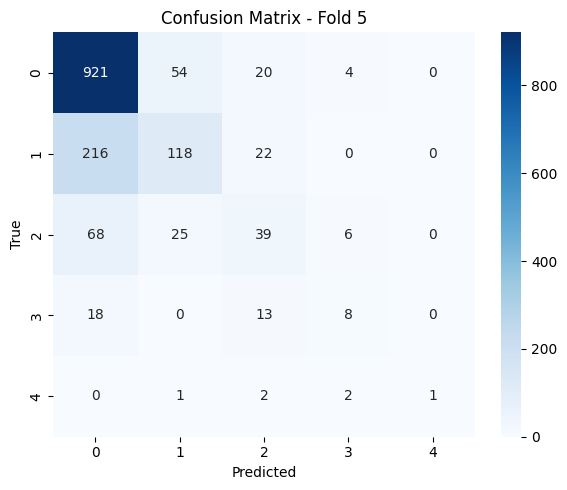

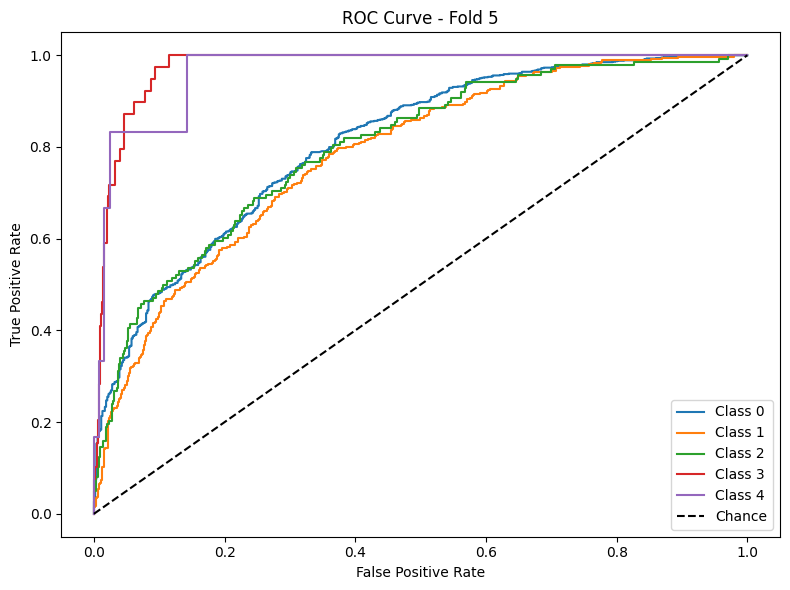


Average Accuracy: 0.7005
Average F1 Macro: 0.3738
Average AUC: 0.8630


In [9]:
# phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
# results = {}

# for i, phase_path in enumerate(phase_paths, start=1):
#     print(f"\n================================================")
#     print(f"\n============== Training Phase {i} ===============")
#     print(f"\n=================================================")
#     sample = False
#     model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
#     # Save best model & scaler
#     if sample: 
#         temp = "sample"
#     else: temp = "no_sample"
#     joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
#     joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
#     results[f"phase{i}"] = metrics

phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # Lưu model keras với .h5
    model.save(f"best_model_{temp}_phase{i}.h5")

    # Lưu scaler sklearn bình thường
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


## Predict on Test Data

In [10]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
from tensorflow.keras.models import load_model

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = load_model(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded'].values  # dạng mảng numpy
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # reshape cho LSTM input: (samples, timesteps=1, features)
    X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

    # Predict probabilities & labels
    y_pred_prob = model.predict(X_test_lstm)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Get unique classes from y_test (hoặc xác định từ dữ liệu train)
    classes = np.unique(np.concatenate((y_test, y_pred)))

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, labels=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       568
           1       0.30      0.21      0.25        63
           2       0.36      0.21      0.26        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.31      0.28      0.29       698
weighted avg       0.76      0.82      0.78       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


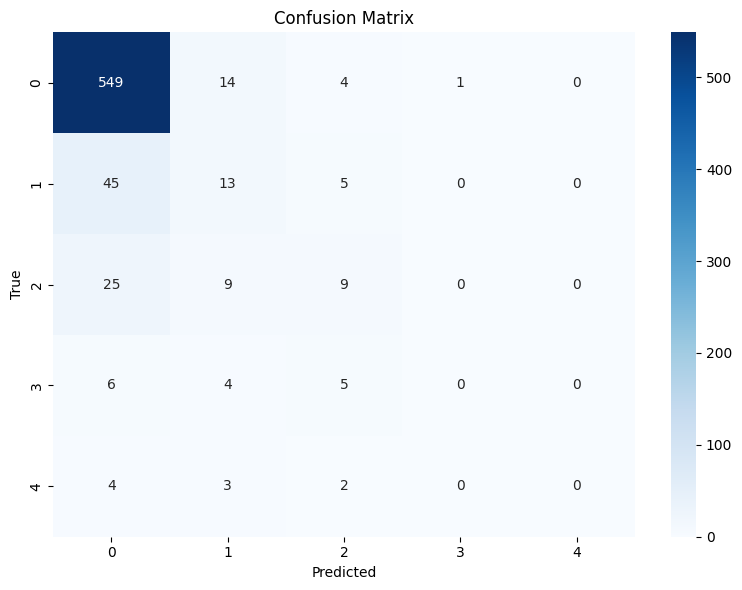


Test AUC (macro-average, OVR): 0.7537


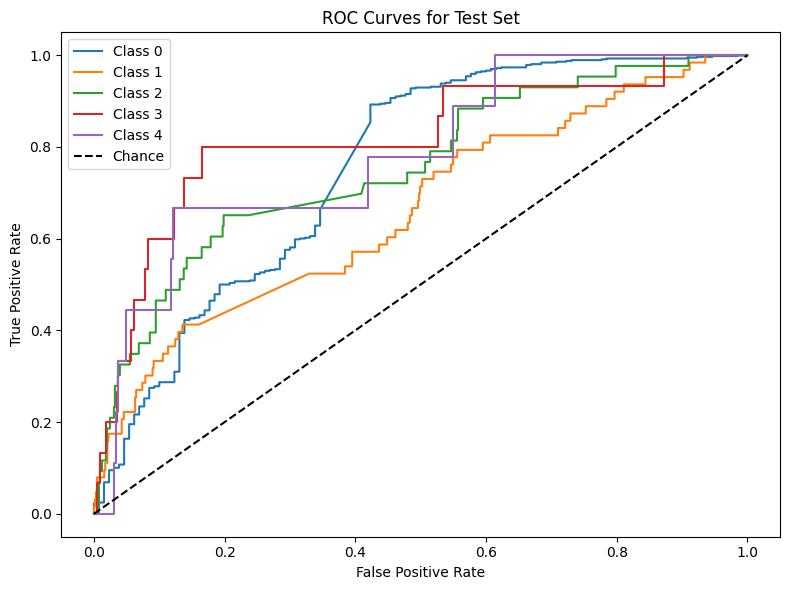

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       544
           1       0.31      0.17      0.22        59
           2       0.24      0.12      0.16        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.28      0.25      0.26       668
weighted avg       0.75      0.82      0.78       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


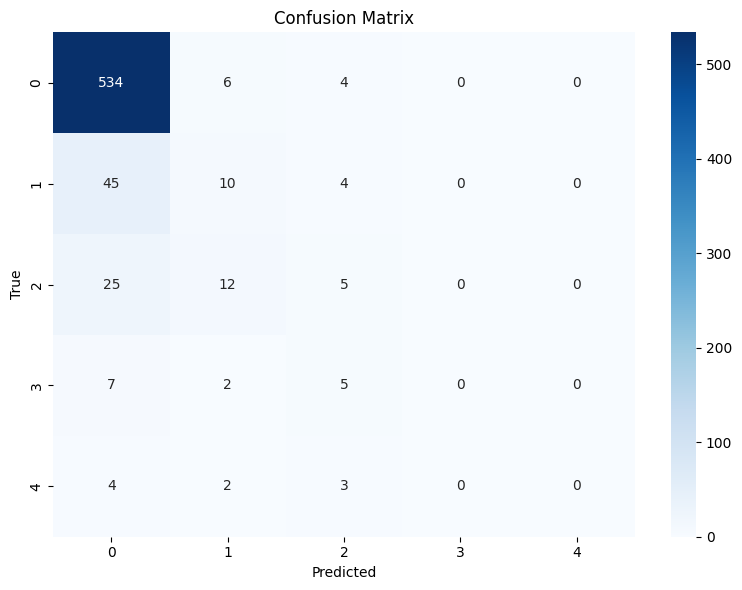


Test AUC (macro-average, OVR): 0.7995


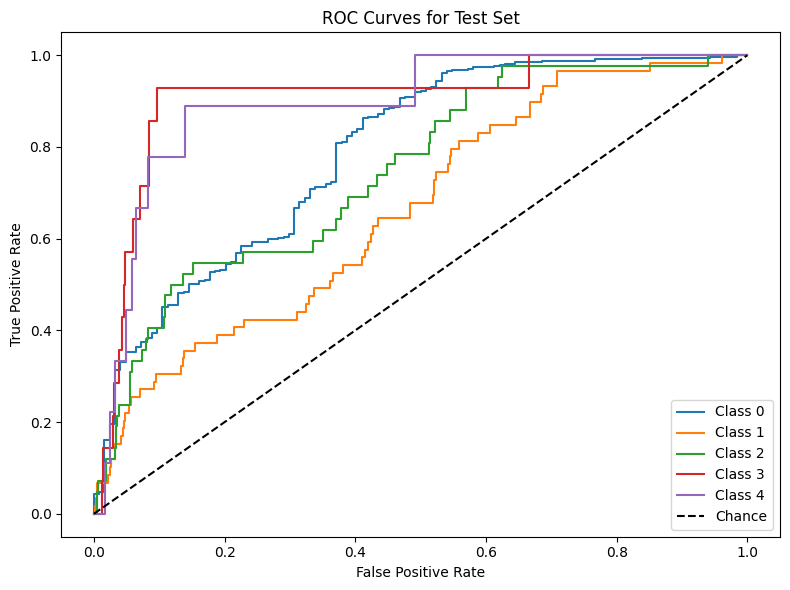

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       455
           1       0.39      0.17      0.24        52
           2       0.28      0.31      0.30        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       554
   macro avg       0.31      0.29      0.29       554
weighted avg       0.78      0.83      0.80       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


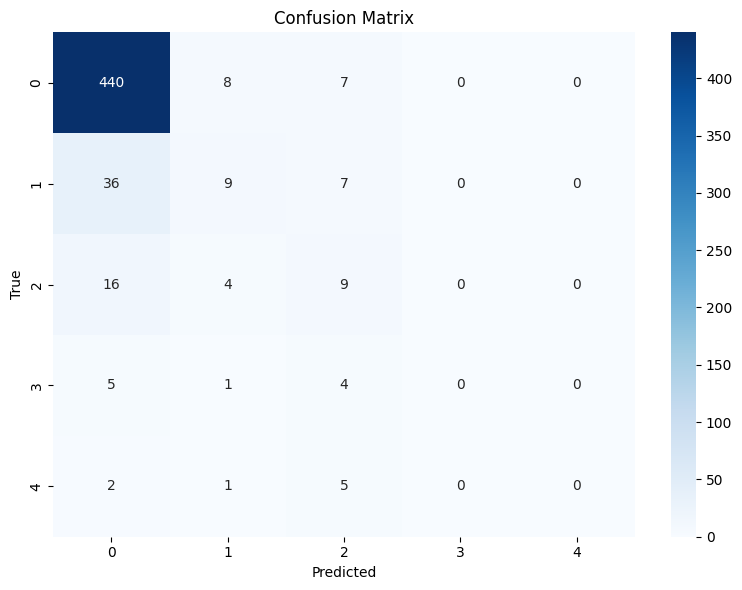


Test AUC (macro-average, OVR): 0.7879


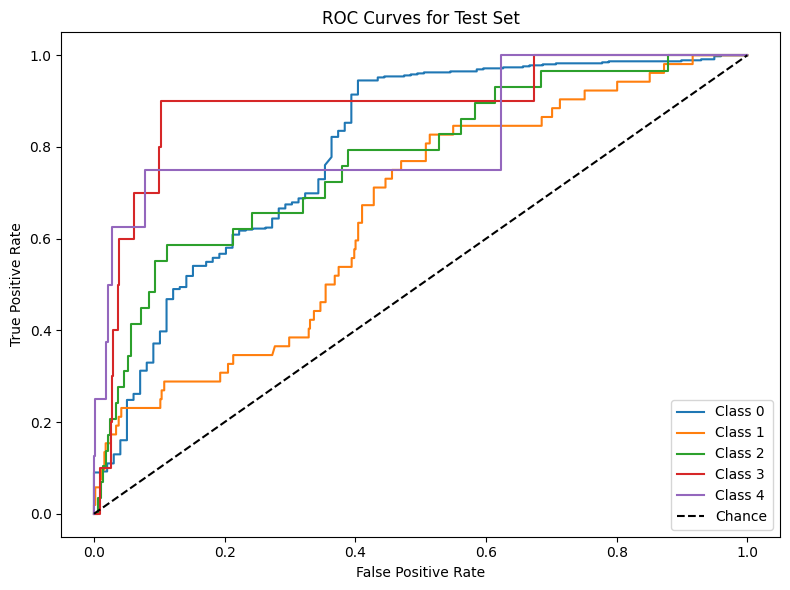

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       395
           1       0.29      0.33      0.31        40
           2       0.22      0.25      0.24        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.28      0.30      0.29       477
weighted avg       0.78      0.81      0.80       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


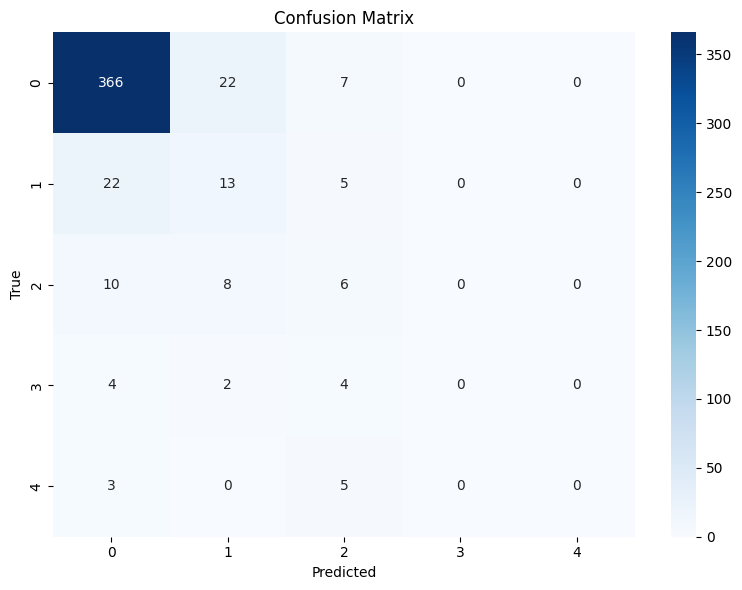


Test AUC (macro-average, OVR): 0.7103


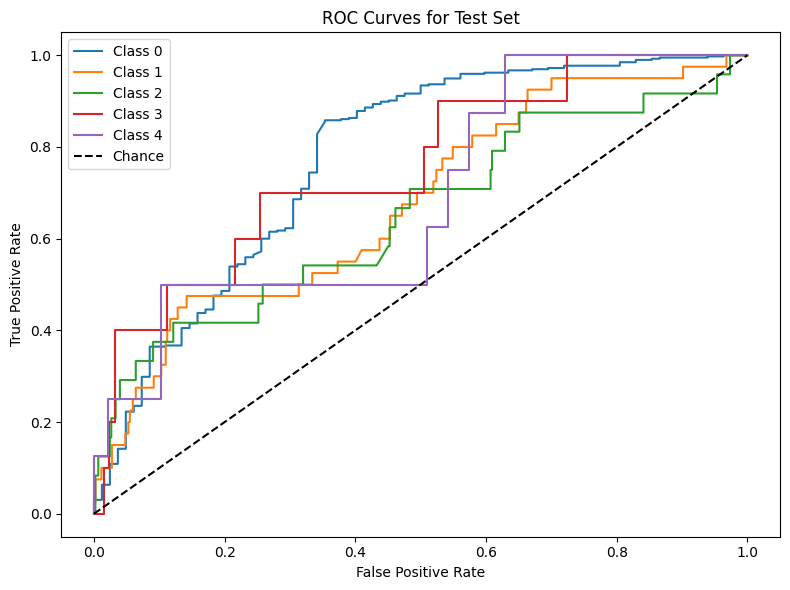

In [11]:
import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)



# temp = "sample"  # hoặc "no_sample" tùy cách lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 5s - 5ms/step - accuracy: 0.6388 - loss: 0.9345 - val_accuracy: 0.5529 - val_loss: 1.0003
Epoch 2/30
987/987 - 2s - 2ms/step - accuracy: 0.6923 - loss: 0.7728 - val_accuracy: 0.5971 - val_loss: 0.9608
Epoch 3/30
987/987 - 2s - 2ms/step - accuracy: 0.7022 - loss: 0.7439 - val_accuracy: 0.5606 - val_loss: 0.9599
Epoch 4/30
987/987 - 2s - 2ms/step - accuracy: 0.7077 - loss: 0.7259 - val_accuracy: 0.6055 - val_loss: 0.9292
Epoch 5/30
987/987 - 2s - 2ms/step - accuracy: 0.7167 - loss: 0.7112 - val_accuracy: 0.5971 - val_loss: 0.9644
Epoch 6/30
987/987 - 2s - 2ms/step - accuracy: 0.7194 - loss: 0.7052 - val_accuracy: 0.6018 - val_loss: 0.9138
Epoch 7/30
987/987 - 2s - 2ms/step - accuracy: 0.7210 - loss: 0.6963 - val_accuracy: 0.6192 - val_loss: 0.9094
Epoch 8/30
987/987 - 2s - 2ms/step - accuracy: 0.7254 - loss: 0.6887 - val_accuracy: 0.6298 - val_loss: 0.9256
Epoch 9/30
987/987 - 2s - 2ms/step - accuracy: 0.7276 - loss: 0.6840 - val_accuracy: 0.6317 - val_loss: 0.8992
Epoch 10/30


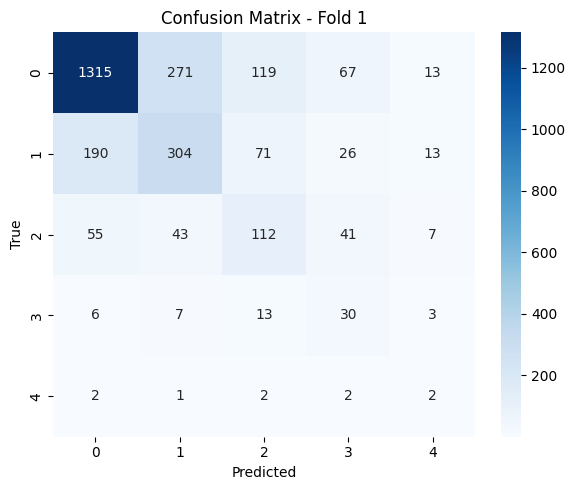

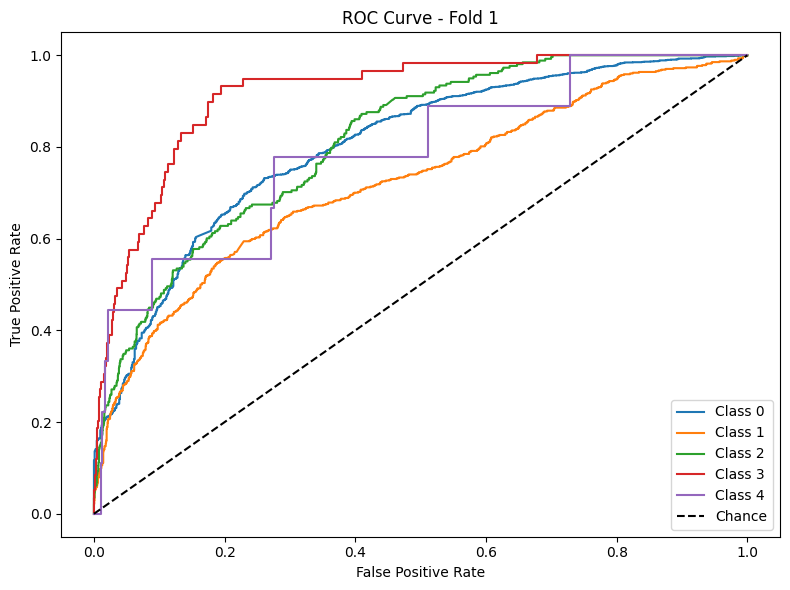

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 6ms/step - accuracy: 0.6507 - loss: 0.9116 - val_accuracy: 0.5446 - val_loss: 1.0269
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.7059 - loss: 0.7476 - val_accuracy: 0.5722 - val_loss: 0.9573
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.7161 - loss: 0.7201 - val_accuracy: 0.5895 - val_loss: 0.9476
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.7211 - loss: 0.7043 - val_accuracy: 0.5608 - val_loss: 0.9349
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.7259 - loss: 0.6918 - val_accuracy: 0.5796 - val_loss: 0.9574
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.7302 - loss: 0.6836 - val_accuracy: 0.6087 - val_loss: 0.9106
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.7314 - loss: 0.6804 - val_accuracy: 0.5925 - val_loss: 0.9323
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.7350 - loss: 0.6743 - val_accuracy: 0.5929 - val_loss: 0.9265
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.7346 - loss: 0.6714 - val_accuracy: 0.5851 - val_loss: 0.9374
Epoch 10/30


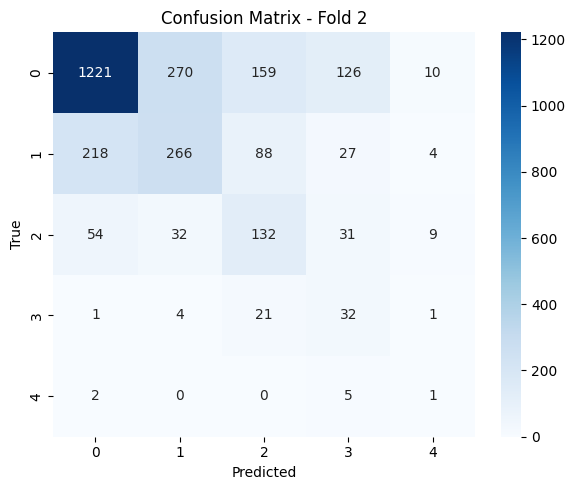

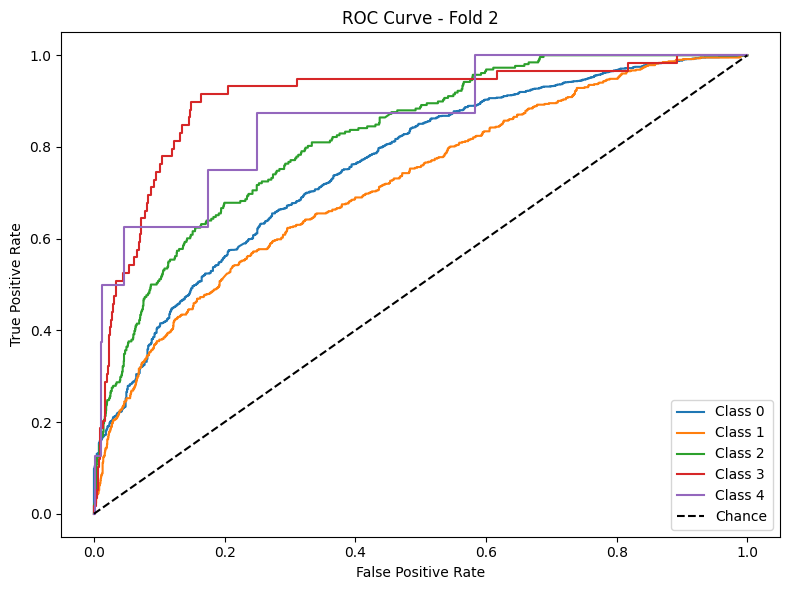

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 7s - 7ms/step - accuracy: 0.6396 - loss: 0.9369 - val_accuracy: 0.5501 - val_loss: 0.9987
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6969 - loss: 0.7686 - val_accuracy: 0.5560 - val_loss: 0.9614
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.7058 - loss: 0.7360 - val_accuracy: 0.5733 - val_loss: 0.9733
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.7137 - loss: 0.7207 - val_accuracy: 0.5520 - val_loss: 0.9432
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.7174 - loss: 0.7060 - val_accuracy: 0.5870 - val_loss: 0.9225
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.7225 - loss: 0.6934 - val_accuracy: 0.6032 - val_loss: 0.9276
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.7238 - loss: 0.6875 - val_accuracy: 0.6043 - val_loss: 0.9132
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.7264 - loss: 0.6822 - val_accuracy: 0.5910 - val_loss: 0.9131
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.7291 - loss: 0.6753 - val_accuracy: 0.6315 - val_loss: 0.8976
Epoch 10/30


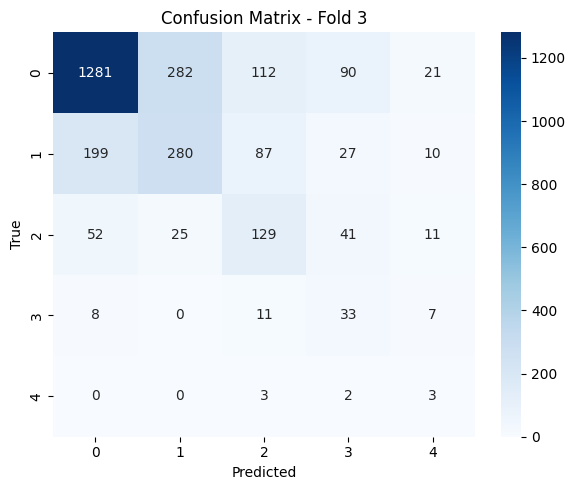

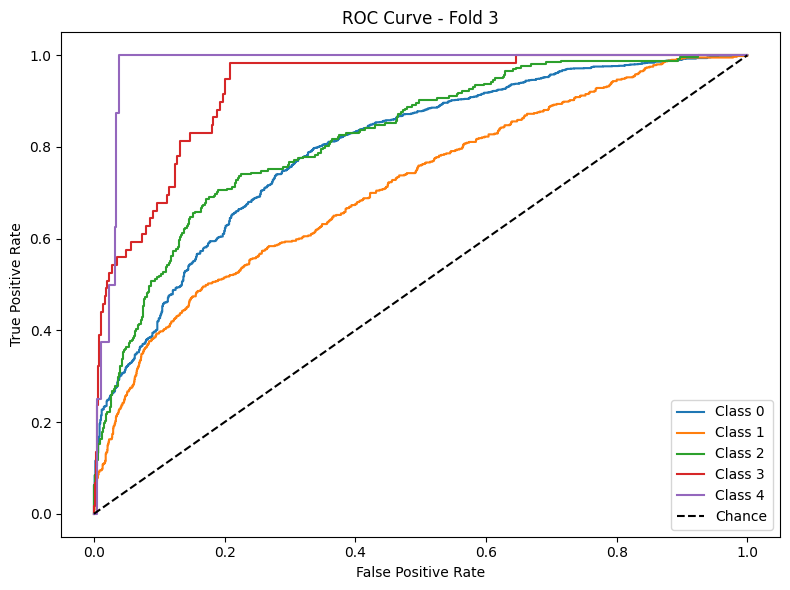

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 5s - 5ms/step - accuracy: 0.6356 - loss: 0.9423 - val_accuracy: 0.5976 - val_loss: 0.9696
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6974 - loss: 0.7684 - val_accuracy: 0.6197 - val_loss: 0.9087
Epoch 3/30
987/987 - 2s - 2ms/step - accuracy: 0.7082 - loss: 0.7327 - val_accuracy: 0.6006 - val_loss: 0.9312
Epoch 4/30
987/987 - 2s - 2ms/step - accuracy: 0.7137 - loss: 0.7184 - val_accuracy: 0.6275 - val_loss: 0.8871
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.7172 - loss: 0.7093 - val_accuracy: 0.6002 - val_loss: 0.9037
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.7213 - loss: 0.6990 - val_accuracy: 0.5973 - val_loss: 0.8950
Epoch 7/30
987/987 - 2s - 2ms/step - accuracy: 0.7255 - loss: 0.6936 - val_accuracy: 0.6297 - val_loss: 0.8987
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.7244 - loss: 0.6876 - val_accuracy: 0.6374 - val_loss: 0.8835
Epoch 9/30
987/987 - 2s - 2ms/step - accuracy: 0.7269 - loss: 0.6824 - val_accuracy: 0.6349 - val_loss: 0.8866
Epoch 10/30


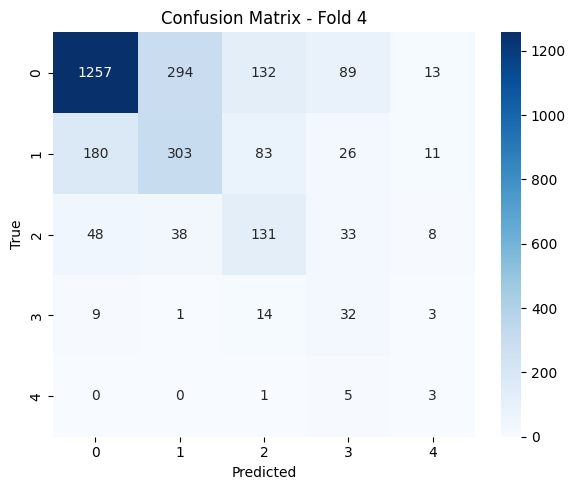

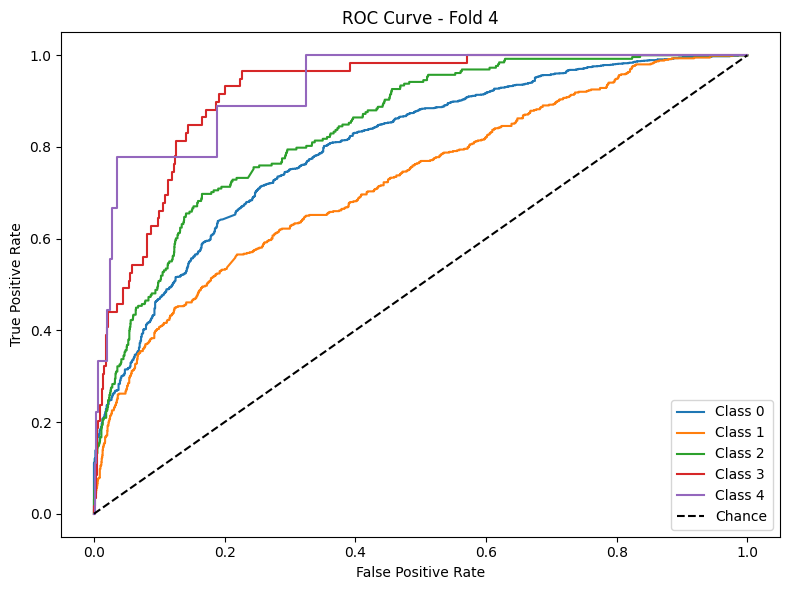

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 5s - 5ms/step - accuracy: 0.6461 - loss: 0.9051 - val_accuracy: 0.5976 - val_loss: 0.9610
Epoch 2/30
987/987 - 2s - 2ms/step - accuracy: 0.7036 - loss: 0.7379 - val_accuracy: 0.6057 - val_loss: 0.9342
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.7150 - loss: 0.7046 - val_accuracy: 0.6271 - val_loss: 0.9204
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.7251 - loss: 0.6835 - val_accuracy: 0.6459 - val_loss: 0.8763
Epoch 5/30
987/987 - 2s - 2ms/step - accuracy: 0.7274 - loss: 0.6744 - val_accuracy: 0.6083 - val_loss: 0.8883
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.7299 - loss: 0.6645 - val_accuracy: 0.6408 - val_loss: 0.8680
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.7346 - loss: 0.6577 - val_accuracy: 0.6396 - val_loss: 0.8828
Epoch 8/30
987/987 - 2s - 3ms/step - accuracy: 0.7360 - loss: 0.6549 - val_accuracy: 0.6562 - val_loss: 0.8779
Epoch 9/30
987/987 - 2s - 2ms/step - accuracy: 0.7385 - loss: 0.6476 - val_accuracy: 0.6606 - val_loss: 0.8707
Epoch 10/30


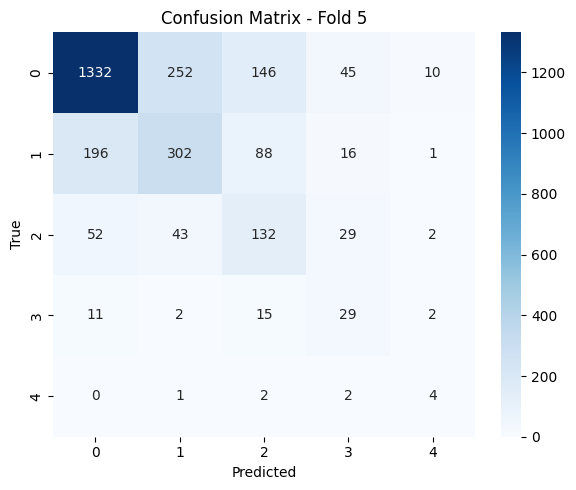

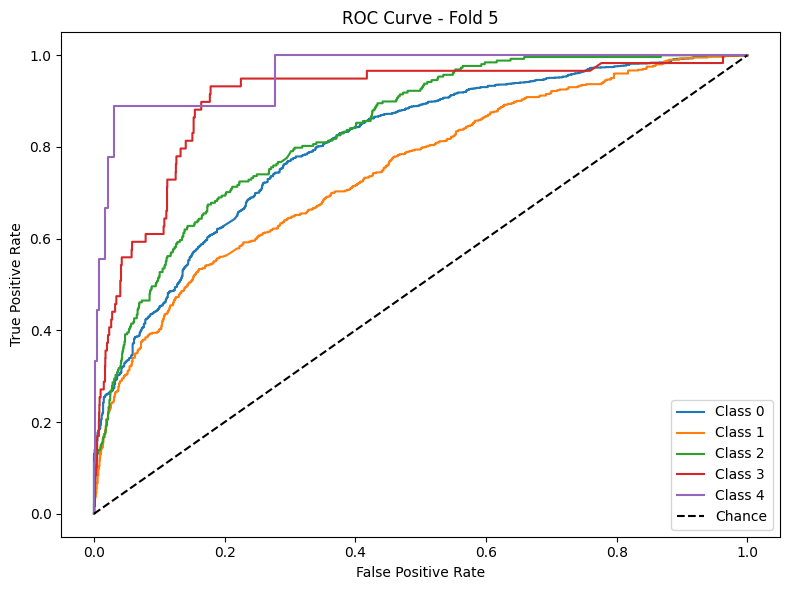


Average Accuracy: 0.6386
Average F1 Macro: 0.4128
Average AUC: 0.8325

=== Training Phase 2 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 5s - 6ms/step - accuracy: 0.6562 - loss: 0.9129 - val_accuracy: 0.6058 - val_loss: 0.9986
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.7042 - loss: 0.7445 - val_accuracy: 0.6137 - val_loss: 0.9685
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.7197 - loss: 0.7140 - val_accuracy: 0.6164 - val_loss: 0.9460
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.7219 - loss: 0.7011 - val_accuracy: 0.6354 - val_loss: 0.9050
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.7233 - loss: 0.6902 - val_accuracy: 0.5965 - val_loss: 0.9513
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.7301 - loss: 0.6772 - val_accuracy: 0.6265 - val_loss: 0.9437
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7327 - loss: 0.6715 - val_accuracy: 0.6372 - val_loss: 0.9126
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7329 - loss: 0.6680 - val_accuracy: 0.6243 - val_loss: 0.9243
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.7353 - loss: 0.6609 - val_accuracy: 0.6389 - val_loss: 0.9066
71/71 ━━━━━━

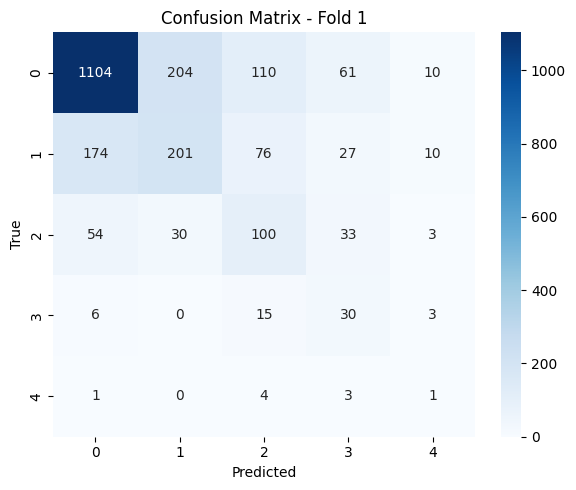

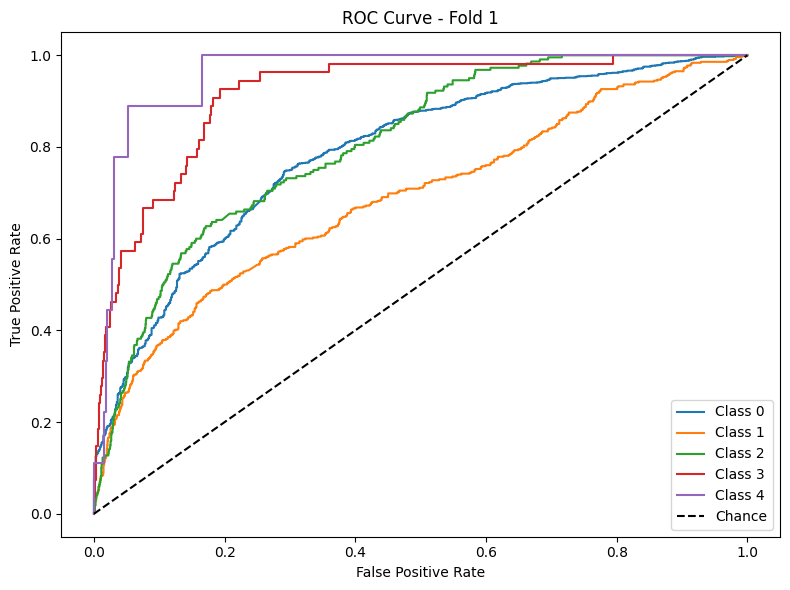

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 5s - 6ms/step - accuracy: 0.6630 - loss: 0.8997 - val_accuracy: 0.5752 - val_loss: 0.9963
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.7154 - loss: 0.7226 - val_accuracy: 0.5982 - val_loss: 0.9333
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.7251 - loss: 0.6913 - val_accuracy: 0.6018 - val_loss: 0.9428
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.7313 - loss: 0.6732 - val_accuracy: 0.5920 - val_loss: 0.9243
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.7351 - loss: 0.6624 - val_accuracy: 0.6111 - val_loss: 0.9164
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.7395 - loss: 0.6528 - val_accuracy: 0.6208 - val_loss: 0.9090
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7448 - loss: 0.6425 - val_accuracy: 0.6332 - val_loss: 0.9037
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7452 - loss: 0.6375 - val_accuracy: 0.6341 - val_loss: 0.9094
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.7456 - loss: 0.6316 - val_accuracy: 0.6221 - val_loss: 0.9043
Epoch 10/30


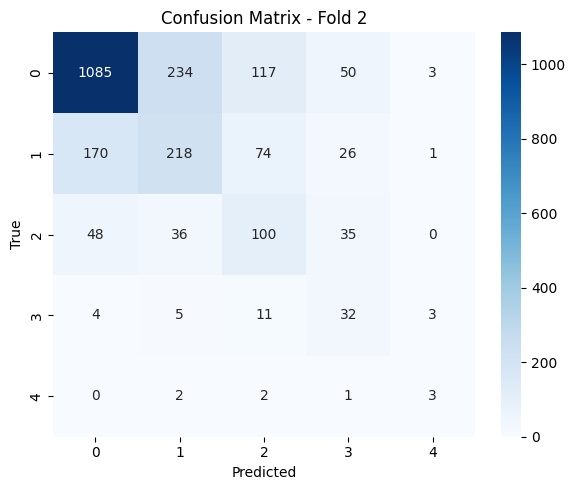

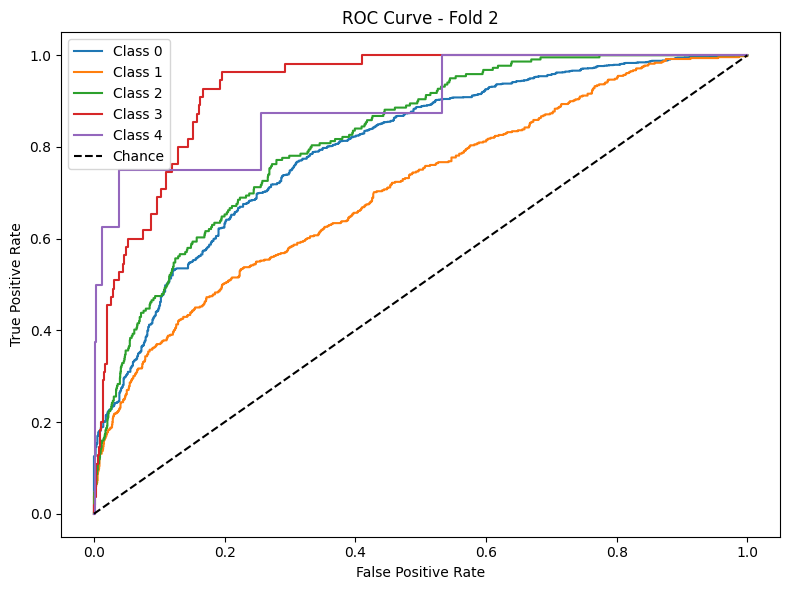

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 5s - 6ms/step - accuracy: 0.6645 - loss: 0.8976 - val_accuracy: 0.5551 - val_loss: 1.0024
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.7127 - loss: 0.7275 - val_accuracy: 0.5826 - val_loss: 0.9727
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.7241 - loss: 0.6970 - val_accuracy: 0.6158 - val_loss: 0.9427
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.7317 - loss: 0.6789 - val_accuracy: 0.5879 - val_loss: 0.9625
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.7346 - loss: 0.6686 - val_accuracy: 0.6047 - val_loss: 0.9485
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.7381 - loss: 0.6567 - val_accuracy: 0.6069 - val_loss: 0.9394
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7440 - loss: 0.6458 - val_accuracy: 0.5901 - val_loss: 0.9528
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7407 - loss: 0.6421 - val_accuracy: 0.6118 - val_loss: 0.9227
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.7447 - loss: 0.6376 - val_accuracy: 0.6091 - val_loss: 0.9316
Epoch 10/30


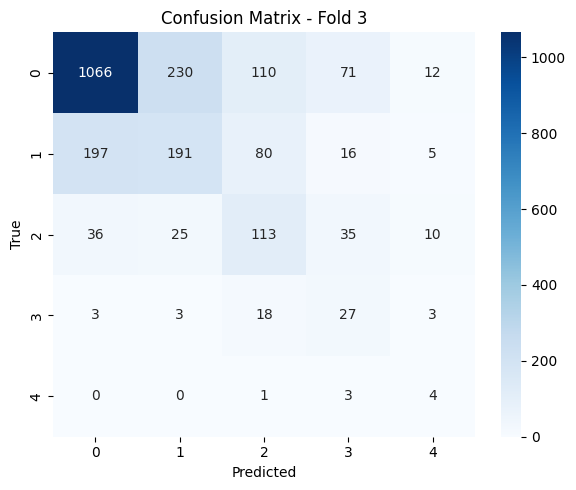

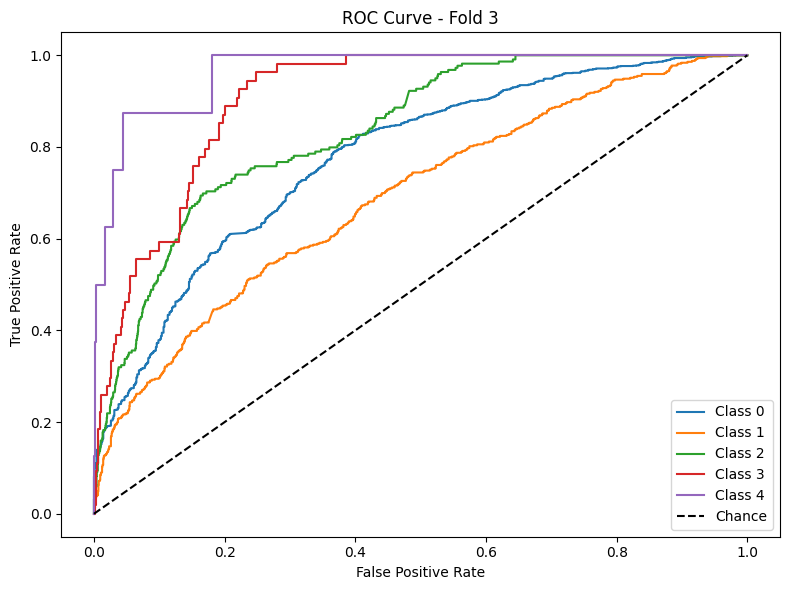

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 5s - 6ms/step - accuracy: 0.6328 - loss: 0.9617 - val_accuracy: 0.5799 - val_loss: 0.9944
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.6907 - loss: 0.7799 - val_accuracy: 0.5821 - val_loss: 0.9464
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.7020 - loss: 0.7502 - val_accuracy: 0.6096 - val_loss: 0.9004
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.7083 - loss: 0.7349 - val_accuracy: 0.6012 - val_loss: 0.9078
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.7130 - loss: 0.7210 - val_accuracy: 0.6206 - val_loss: 0.8843
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.7179 - loss: 0.7122 - val_accuracy: 0.6065 - val_loss: 0.9088
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7211 - loss: 0.7053 - val_accuracy: 0.6184 - val_loss: 0.9112
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7250 - loss: 0.6982 - val_accuracy: 0.6379 - val_loss: 0.8970
Epoch 9/30
824/824 - 3s - 3ms/step - accuracy: 0.7288 - loss: 0.6898 - val_accuracy: 0.6313 - val_loss: 0.8852
Epoch 10/30


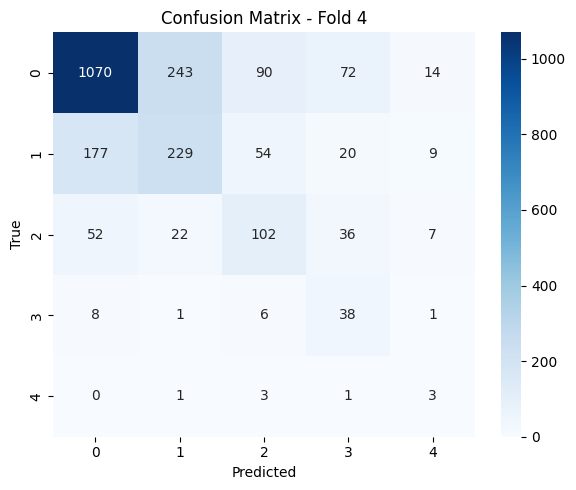

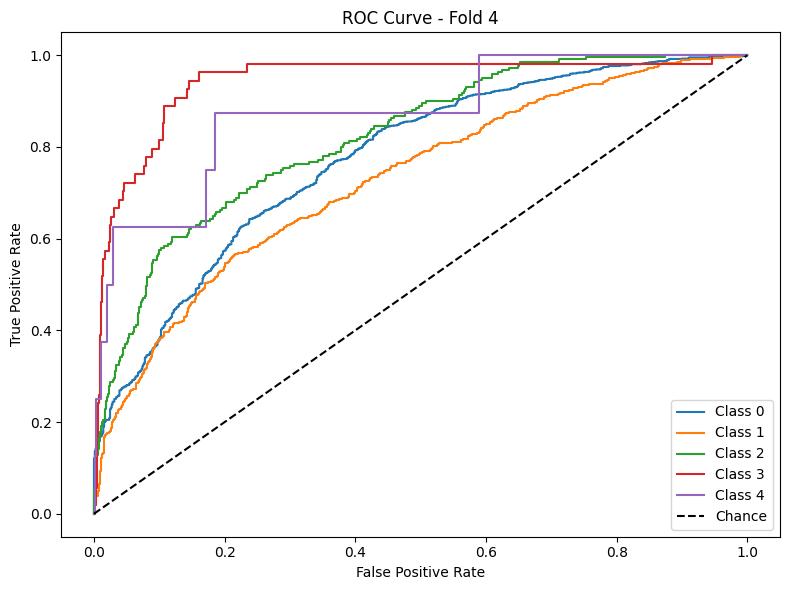

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 7s - 8ms/step - accuracy: 0.6654 - loss: 0.8968 - val_accuracy: 0.6025 - val_loss: 1.0098
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.7198 - loss: 0.7259 - val_accuracy: 0.5857 - val_loss: 0.9689
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.7244 - loss: 0.7008 - val_accuracy: 0.6051 - val_loss: 0.9360
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.7331 - loss: 0.6858 - val_accuracy: 0.5861 - val_loss: 0.9530
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.7396 - loss: 0.6701 - val_accuracy: 0.6078 - val_loss: 0.9193
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.7422 - loss: 0.6609 - val_accuracy: 0.6264 - val_loss: 0.8997
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7443 - loss: 0.6557 - val_accuracy: 0.6162 - val_loss: 0.9152
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7430 - loss: 0.6498 - val_accuracy: 0.6304 - val_loss: 0.9119
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.7472 - loss: 0.6421 - val_accuracy: 0.6357 - val_loss: 0.9052
Epoch 10/30


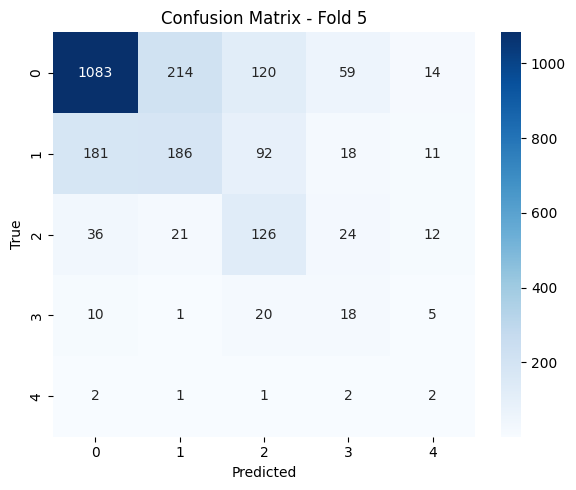

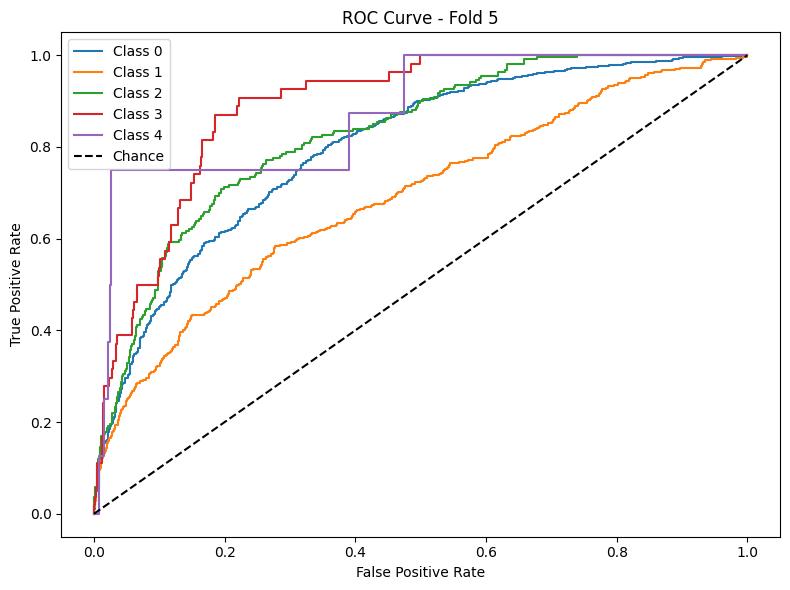


Average Accuracy: 0.6313
Average F1 Macro: 0.4115
Average AUC: 0.8281

=== Training Phase 3 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 5s - 7ms/step - accuracy: 0.6502 - loss: 0.9242 - val_accuracy: 0.5723 - val_loss: 1.0063
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.7186 - loss: 0.7205 - val_accuracy: 0.6239 - val_loss: 0.9418
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.7358 - loss: 0.6812 - val_accuracy: 0.5810 - val_loss: 0.9596
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7455 - loss: 0.6613 - val_accuracy: 0.6133 - val_loss: 0.9228
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7487 - loss: 0.6493 - val_accuracy: 0.6581 - val_loss: 0.8930
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7527 - loss: 0.6376 - val_accuracy: 0.6509 - val_loss: 0.8847
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7582 - loss: 0.6282 - val_accuracy: 0.6234 - val_loss: 0.9148
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7603 - loss: 0.6196 - val_accuracy: 0.6302 - val_loss: 0.9193
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7606 - loss: 0.6180 - val_accuracy: 0.6360 - val_loss: 0.8969
Epoch 10/30


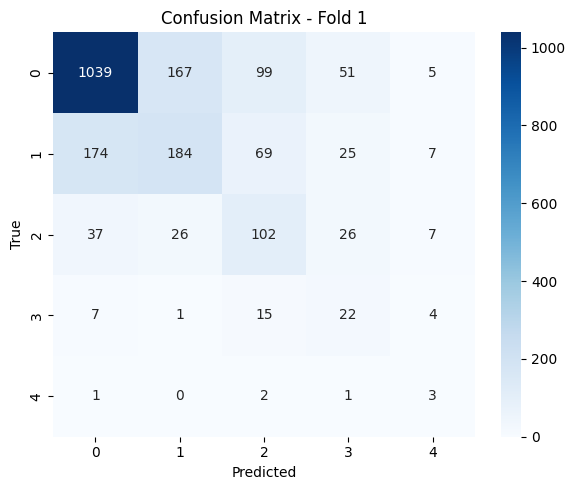

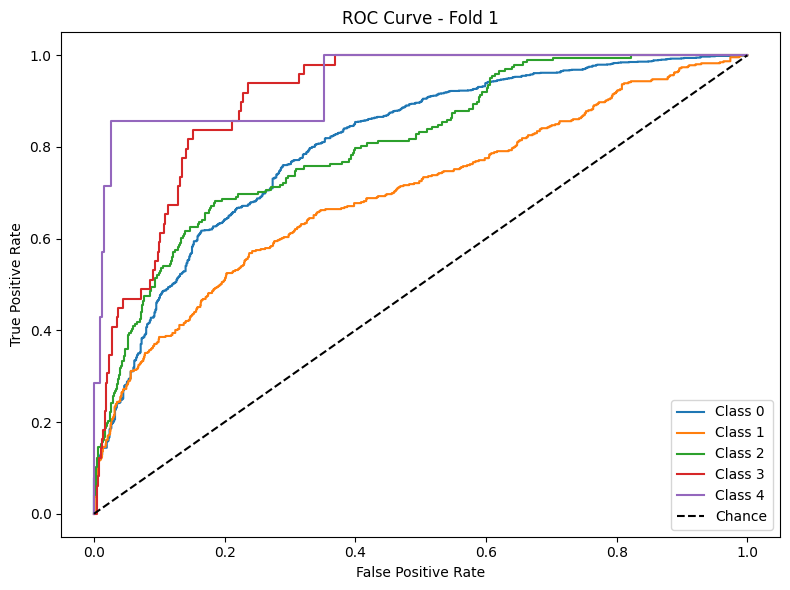

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 5s - 7ms/step - accuracy: 0.6589 - loss: 0.9202 - val_accuracy: 0.5950 - val_loss: 0.9767
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.7211 - loss: 0.7220 - val_accuracy: 0.6172 - val_loss: 0.9723
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.7328 - loss: 0.6870 - val_accuracy: 0.6225 - val_loss: 0.9272
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7367 - loss: 0.6783 - val_accuracy: 0.6148 - val_loss: 0.9410
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7395 - loss: 0.6625 - val_accuracy: 0.6258 - val_loss: 0.9248
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7435 - loss: 0.6551 - val_accuracy: 0.6509 - val_loss: 0.8879
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7485 - loss: 0.6454 - val_accuracy: 0.6384 - val_loss: 0.9137
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7518 - loss: 0.6351 - val_accuracy: 0.6340 - val_loss: 0.9064
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7512 - loss: 0.6320 - val_accuracy: 0.6268 - val_loss: 0.9239
Epoch 10/30


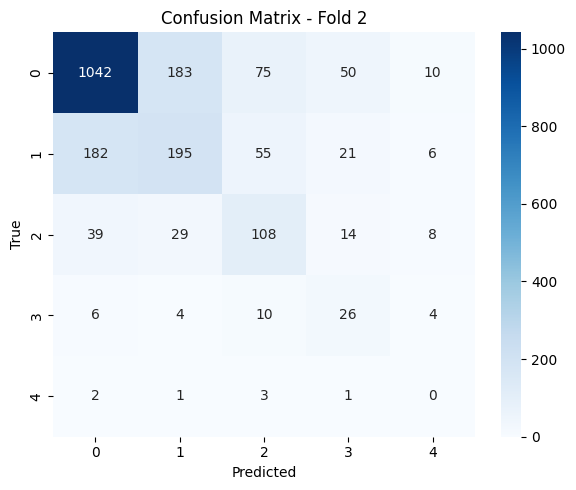

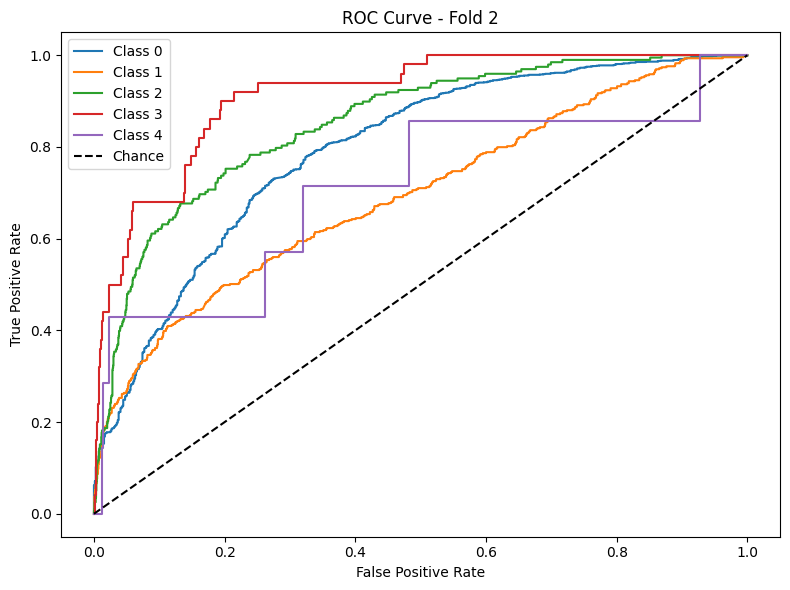

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 6s - 8ms/step - accuracy: 0.6432 - loss: 0.9312 - val_accuracy: 0.5622 - val_loss: 1.0392
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.7125 - loss: 0.7365 - val_accuracy: 0.5603 - val_loss: 0.9808
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.7192 - loss: 0.7026 - val_accuracy: 0.5723 - val_loss: 0.9808
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7322 - loss: 0.6837 - val_accuracy: 0.6210 - val_loss: 0.9228
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7373 - loss: 0.6709 - val_accuracy: 0.5858 - val_loss: 0.9643
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7385 - loss: 0.6619 - val_accuracy: 0.6210 - val_loss: 0.9370
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7458 - loss: 0.6475 - val_accuracy: 0.6032 - val_loss: 0.9334
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7504 - loss: 0.6408 - val_accuracy: 0.6143 - val_loss: 0.9329
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7479 - loss: 0.6403 - val_accuracy: 0.6210 - val_loss: 0.9519
65/65 ━━━━━━

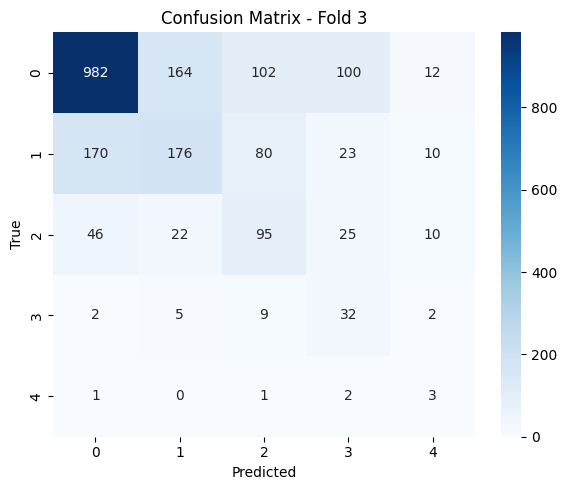

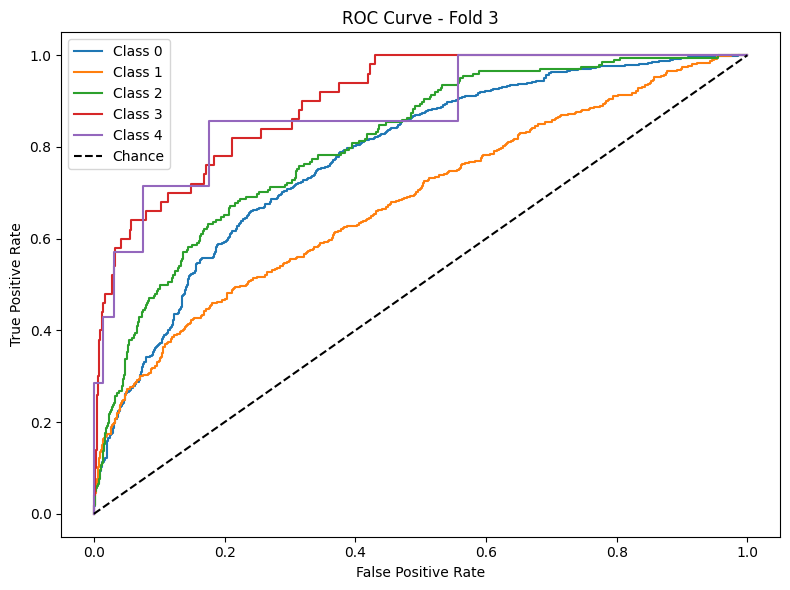

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 5s - 7ms/step - accuracy: 0.6544 - loss: 0.9287 - val_accuracy: 0.5940 - val_loss: 0.9902
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.7152 - loss: 0.7327 - val_accuracy: 0.6485 - val_loss: 0.9201
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.7292 - loss: 0.6975 - val_accuracy: 0.6172 - val_loss: 0.9433
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7317 - loss: 0.6833 - val_accuracy: 0.6379 - val_loss: 0.9060
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7414 - loss: 0.6627 - val_accuracy: 0.6297 - val_loss: 0.9205
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7445 - loss: 0.6535 - val_accuracy: 0.6369 - val_loss: 0.9022
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7477 - loss: 0.6436 - val_accuracy: 0.6413 - val_loss: 0.8842
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7497 - loss: 0.6368 - val_accuracy: 0.6316 - val_loss: 0.9120
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7531 - loss: 0.6275 - val_accuracy: 0.6456 - val_loss: 0.8986
Epoch 10/30


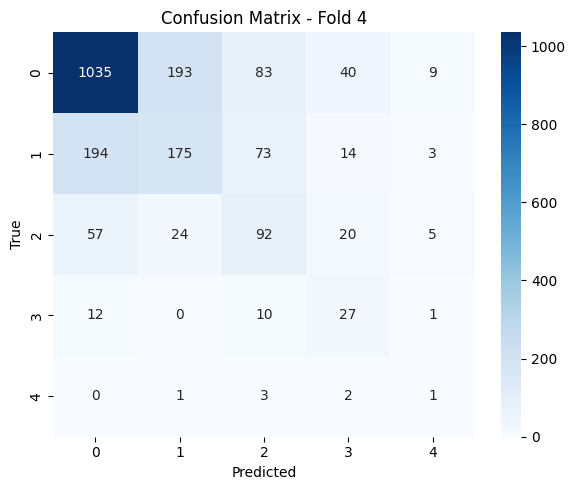

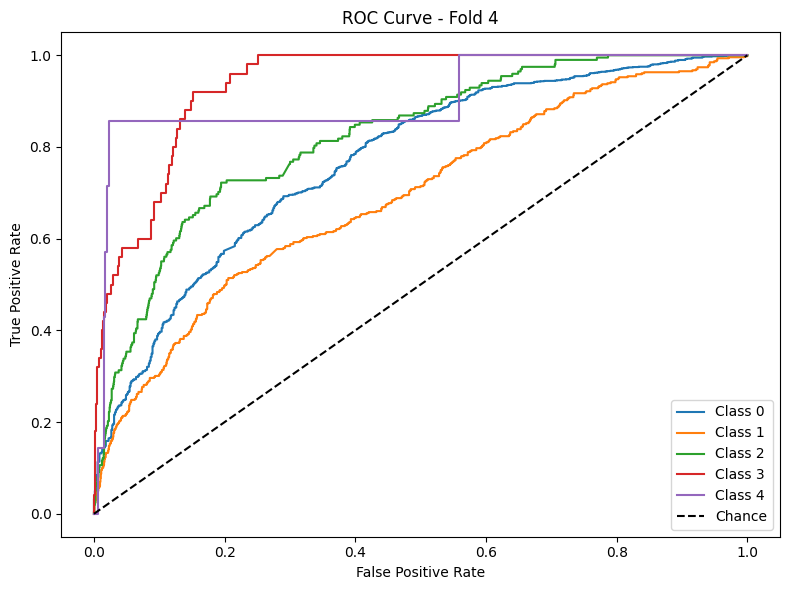

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 5s - 7ms/step - accuracy: 0.6575 - loss: 0.9120 - val_accuracy: 0.5861 - val_loss: 0.9890
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.7188 - loss: 0.7269 - val_accuracy: 0.6233 - val_loss: 0.9742
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.7336 - loss: 0.6927 - val_accuracy: 0.6290 - val_loss: 0.9445
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7371 - loss: 0.6739 - val_accuracy: 0.6122 - val_loss: 0.9820
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7421 - loss: 0.6627 - val_accuracy: 0.6204 - val_loss: 0.9382
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7464 - loss: 0.6539 - val_accuracy: 0.6189 - val_loss: 0.9439
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7524 - loss: 0.6419 - val_accuracy: 0.6358 - val_loss: 0.9482
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7535 - loss: 0.6384 - val_accuracy: 0.6155 - val_loss: 0.9308
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7529 - loss: 0.6345 - val_accuracy: 0.6228 - val_loss: 0.9485
Epoch 10/30


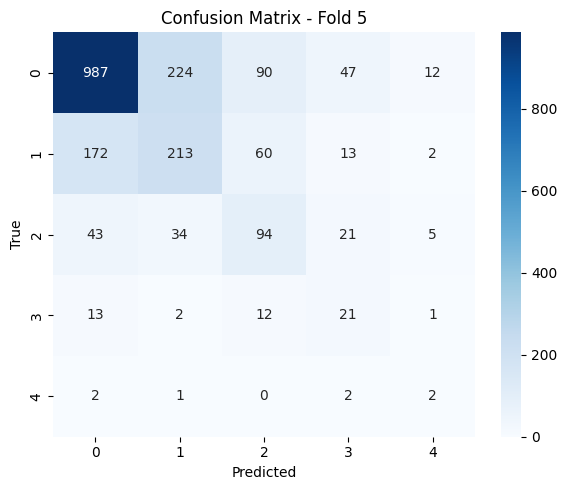

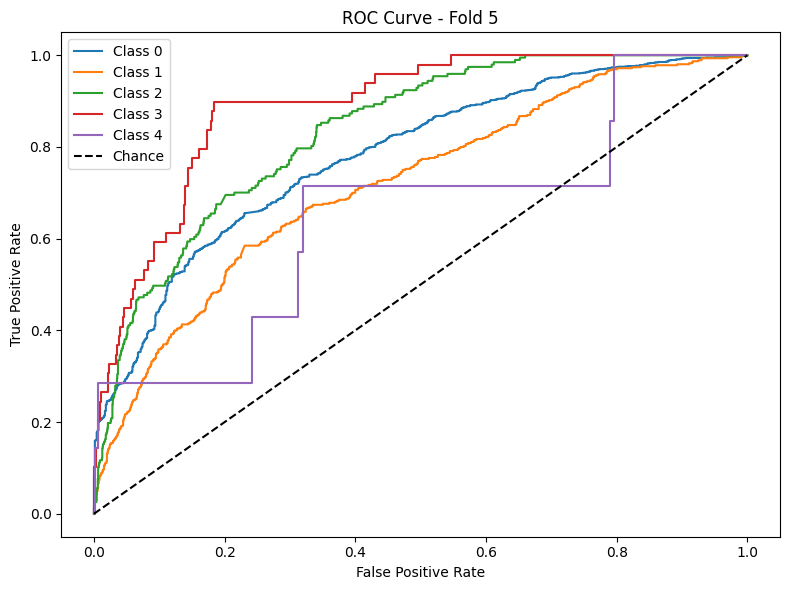


Average Accuracy: 0.6419
Average F1 Macro: 0.4079
Average AUC: 0.8064

=== Training Phase 4 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 8ms/step - accuracy: 0.6506 - loss: 0.9488 - val_accuracy: 0.5776 - val_loss: 1.0410
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7296 - loss: 0.7089 - val_accuracy: 0.5952 - val_loss: 0.9836
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7446 - loss: 0.6639 - val_accuracy: 0.6602 - val_loss: 0.9177
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7540 - loss: 0.6296 - val_accuracy: 0.6075 - val_loss: 0.9375
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7607 - loss: 0.6176 - val_accuracy: 0.6238 - val_loss: 0.9208
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7649 - loss: 0.6032 - val_accuracy: 0.6218 - val_loss: 0.8927
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7667 - loss: 0.5938 - val_accuracy: 0.6017 - val_loss: 0.9517
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7721 - loss: 0.5784 - val_accuracy: 0.6244 - val_loss: 0.9149
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7738 - loss: 0.5732 - val_accuracy: 0.6082 - val_loss: 0.9362
Epoch 10/30


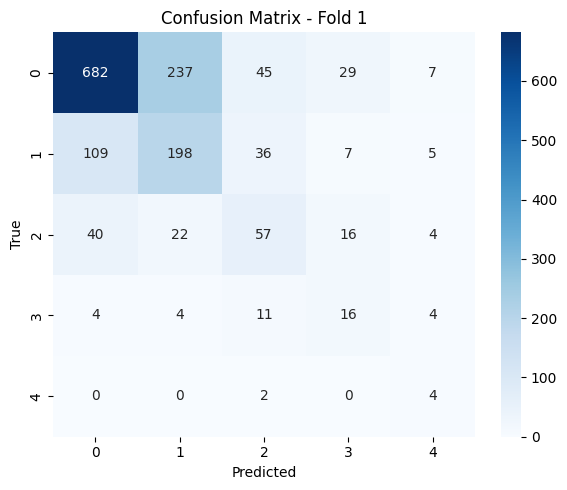

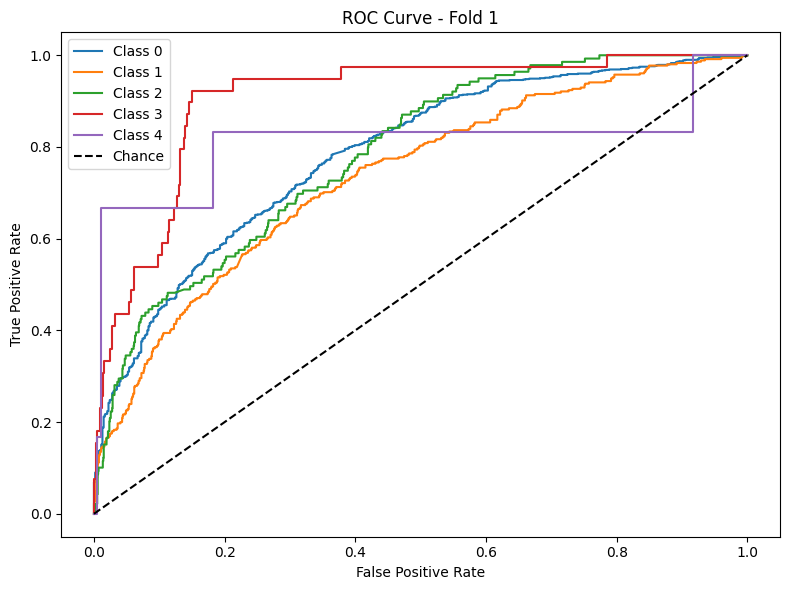

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 6s - 11ms/step - accuracy: 0.6665 - loss: 0.9182 - val_accuracy: 0.6036 - val_loss: 0.9842
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7440 - loss: 0.6826 - val_accuracy: 0.6309 - val_loss: 0.9464
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7566 - loss: 0.6401 - val_accuracy: 0.6023 - val_loss: 0.9441
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7648 - loss: 0.6142 - val_accuracy: 0.6270 - val_loss: 0.9142
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7683 - loss: 0.6055 - val_accuracy: 0.6166 - val_loss: 0.9023
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7727 - loss: 0.5898 - val_accuracy: 0.6342 - val_loss: 0.8987
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7732 - loss: 0.5843 - val_accuracy: 0.6439 - val_loss: 0.8648
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7794 - loss: 0.5746 - val_accuracy: 0.6257 - val_loss: 0.8943
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7809 - loss: 0.5656 - val_accuracy: 0.6374 - val_loss: 0.9004
Epoch 10/30

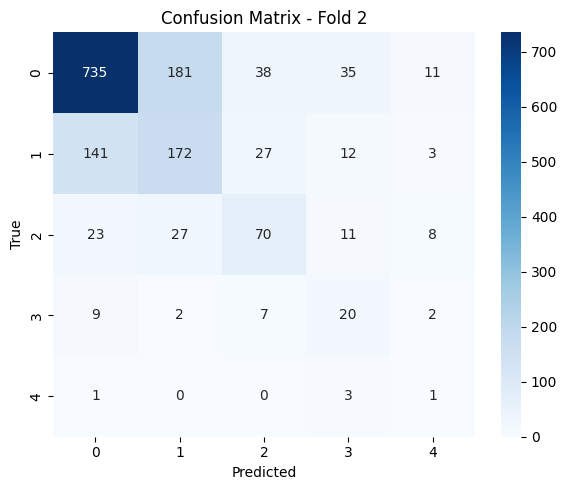

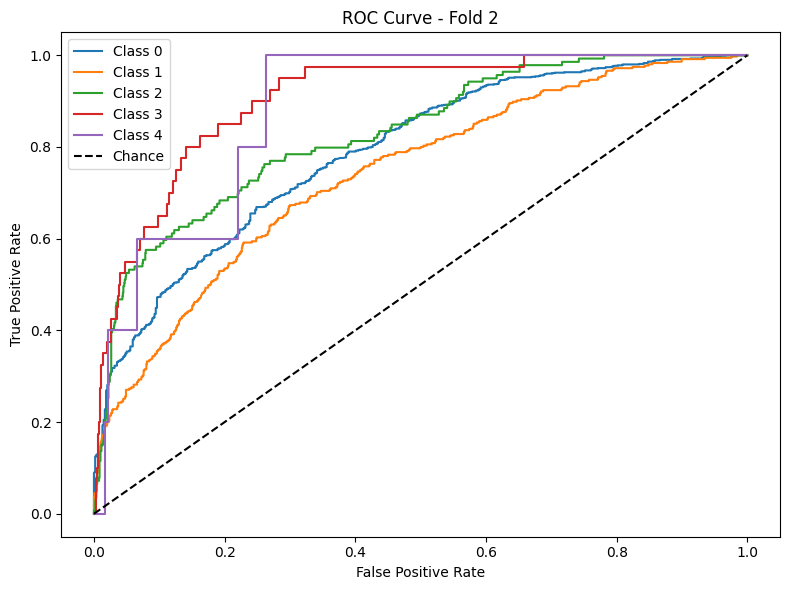

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 9ms/step - accuracy: 0.6684 - loss: 0.9249 - val_accuracy: 0.6108 - val_loss: 1.0096
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7381 - loss: 0.6910 - val_accuracy: 0.6108 - val_loss: 0.9551
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7499 - loss: 0.6516 - val_accuracy: 0.5926 - val_loss: 0.9668
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7586 - loss: 0.6278 - val_accuracy: 0.6335 - val_loss: 0.9300
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7648 - loss: 0.6102 - val_accuracy: 0.6108 - val_loss: 0.9288
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7730 - loss: 0.5991 - val_accuracy: 0.6537 - val_loss: 0.9157
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7768 - loss: 0.5873 - val_accuracy: 0.6257 - val_loss: 0.8847
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7759 - loss: 0.5807 - val_accuracy: 0.6589 - val_loss: 0.8993
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7806 - loss: 0.5738 - val_accuracy: 0.6303 - val_loss: 0.8851
Epoch 10/30


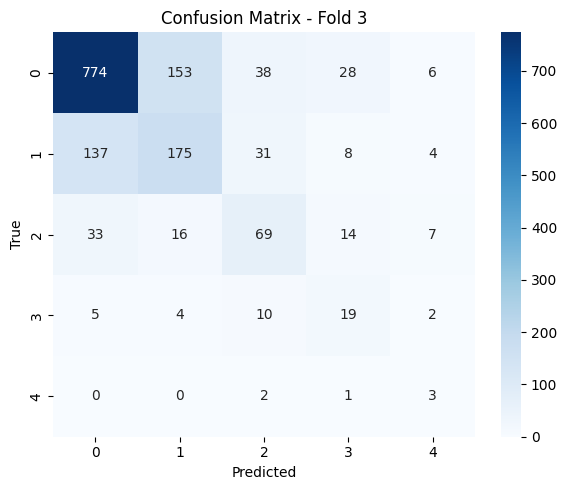

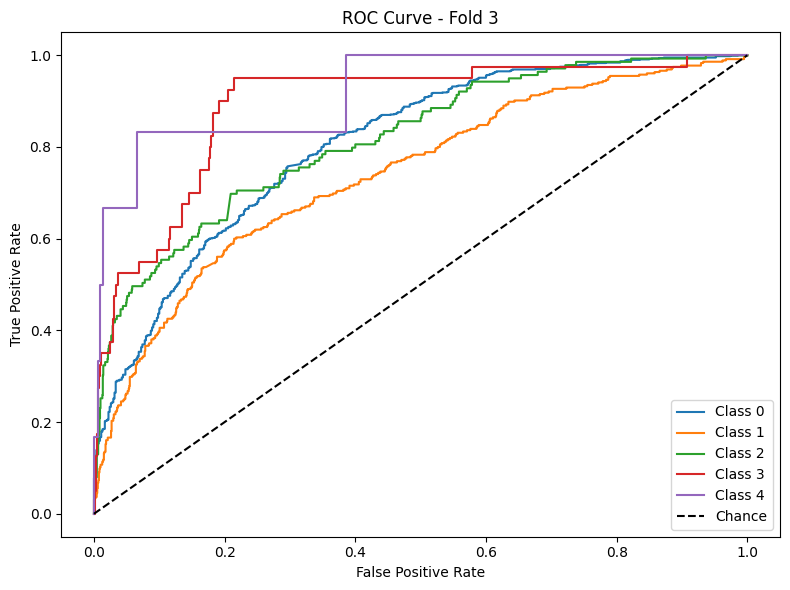

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 8ms/step - accuracy: 0.6618 - loss: 0.9362 - val_accuracy: 0.5956 - val_loss: 0.9977
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7281 - loss: 0.7072 - val_accuracy: 0.6456 - val_loss: 0.9246
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7446 - loss: 0.6635 - val_accuracy: 0.6131 - val_loss: 0.9399
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7558 - loss: 0.6374 - val_accuracy: 0.6209 - val_loss: 0.9286
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7591 - loss: 0.6223 - val_accuracy: 0.6437 - val_loss: 0.9001
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7646 - loss: 0.6063 - val_accuracy: 0.6352 - val_loss: 0.9009
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7663 - loss: 0.6009 - val_accuracy: 0.6541 - val_loss: 0.8457
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7750 - loss: 0.5877 - val_accuracy: 0.6573 - val_loss: 0.8601
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7755 - loss: 0.5824 - val_accuracy: 0.6586 - val_loss: 0.8617
Epoch 10/30


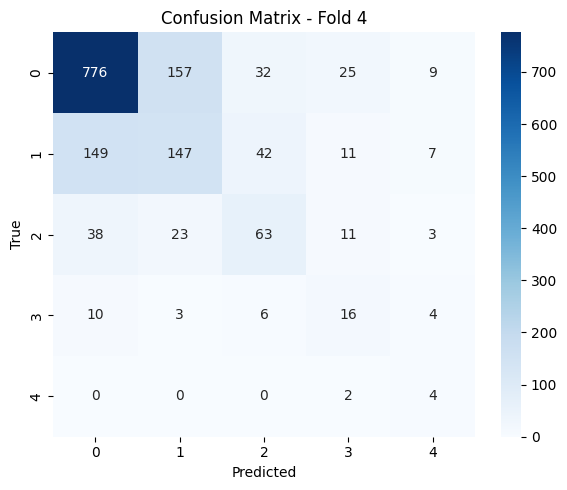

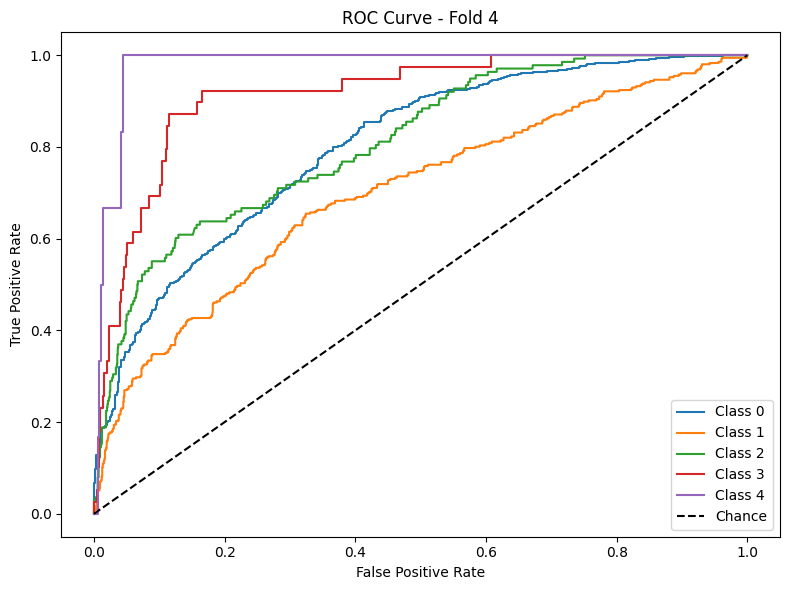

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 8ms/step - accuracy: 0.6662 - loss: 0.9252 - val_accuracy: 0.5819 - val_loss: 1.0246
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7349 - loss: 0.7002 - val_accuracy: 0.5975 - val_loss: 0.9741
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7506 - loss: 0.6508 - val_accuracy: 0.6222 - val_loss: 0.9369
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7548 - loss: 0.6282 - val_accuracy: 0.6398 - val_loss: 0.9263
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7629 - loss: 0.6131 - val_accuracy: 0.6112 - val_loss: 0.9325
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7688 - loss: 0.6013 - val_accuracy: 0.6320 - val_loss: 0.9162
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7726 - loss: 0.5889 - val_accuracy: 0.6255 - val_loss: 0.9113
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7760 - loss: 0.5809 - val_accuracy: 0.6404 - val_loss: 0.8965
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7830 - loss: 0.5732 - val_accuracy: 0.6554 - val_loss: 0.8895
Epoch 10/30


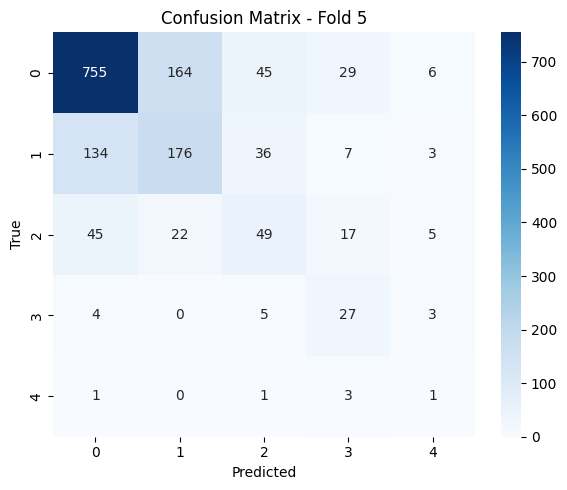

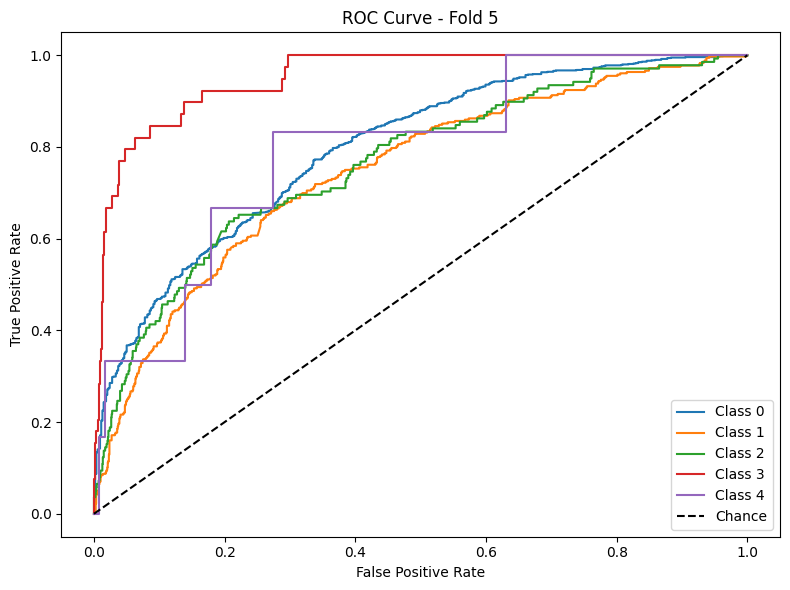


Average Accuracy: 0.6511
Average F1 Macro: 0.4407
Average AUC: 0.8238


In [12]:


phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # Lưu model keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # Lưu scaler sklearn
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       568
           1       0.15      0.32      0.20        63
           2       0.27      0.23      0.25        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.71       698
   macro avg       0.26      0.27      0.26       698
weighted avg       0.75      0.71      0.72       698



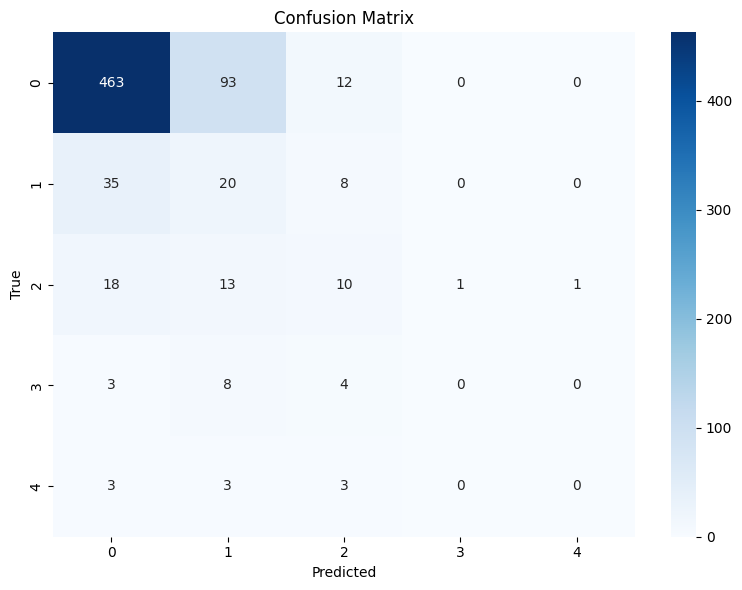


Test AUC (macro-average, OVR): 0.6865


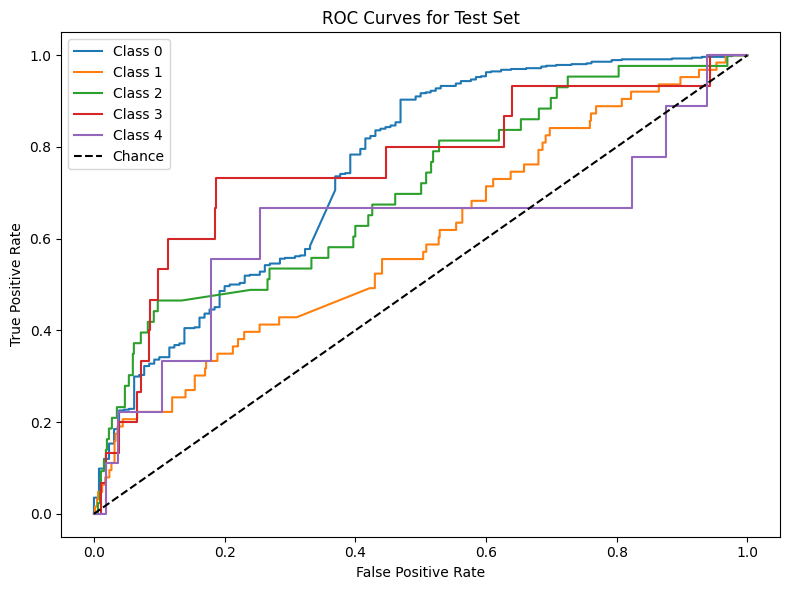

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       544
           1       0.23      0.17      0.19        59
           2       0.24      0.24      0.24        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.80       668
   macro avg       0.27      0.27      0.27       668
weighted avg       0.76      0.80      0.78       668



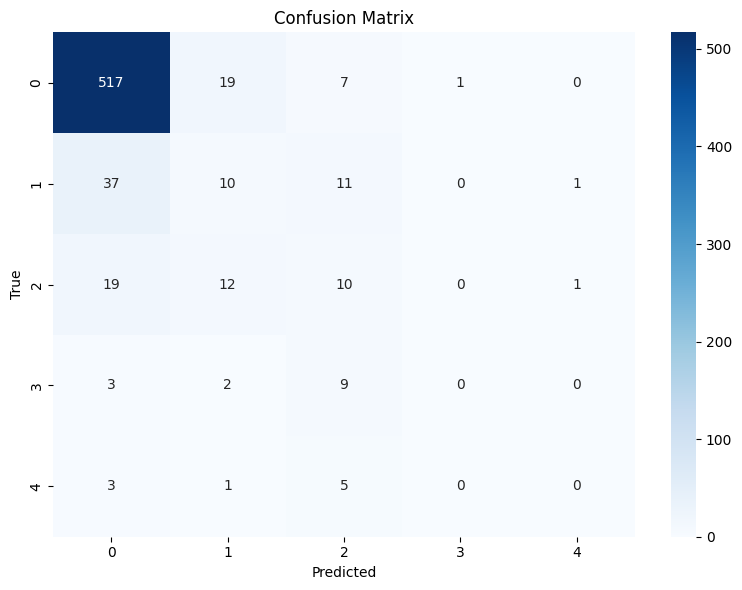


Test AUC (macro-average, OVR): 0.7041


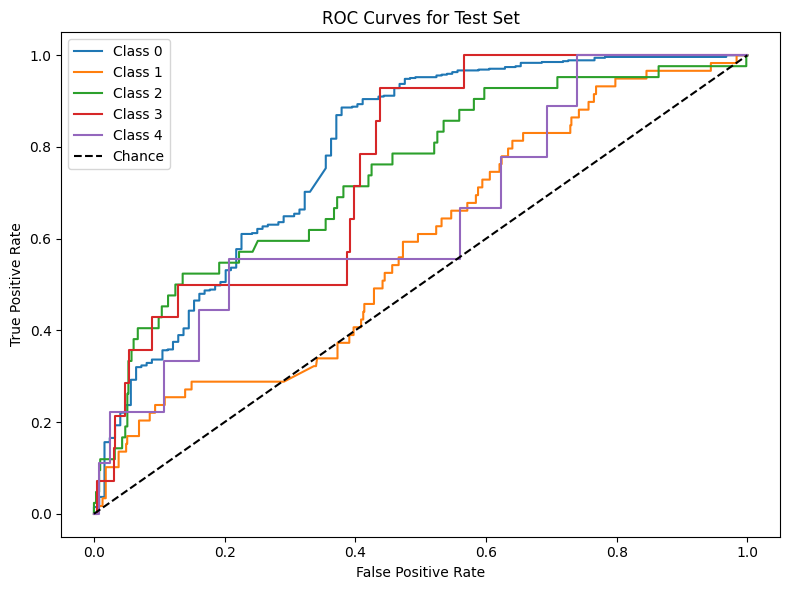

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       455
           1       0.28      0.31      0.29        52
           2       0.22      0.17      0.19        29
           3       0.06      0.10      0.08        10
           4       0.00      0.00      0.00         8

    accuracy                           0.78       554
   macro avg       0.29      0.30      0.29       554
weighted avg       0.78      0.78      0.78       554



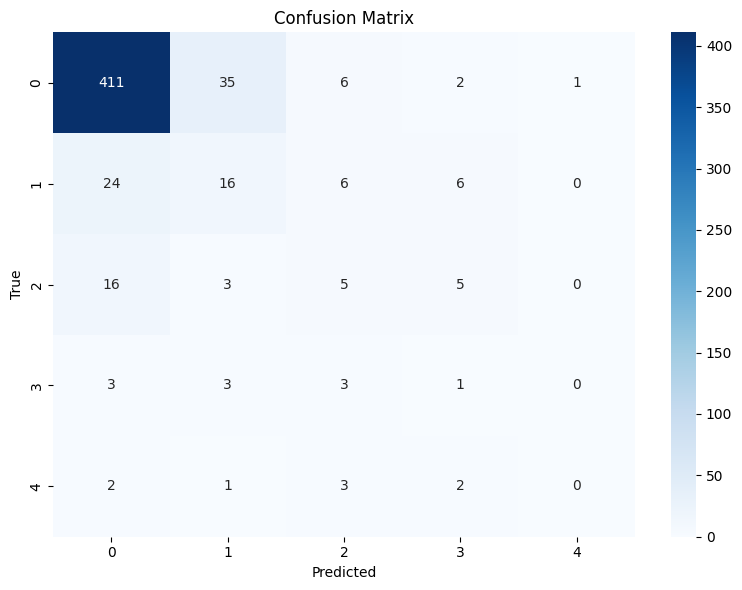


Test AUC (macro-average, OVR): 0.7360


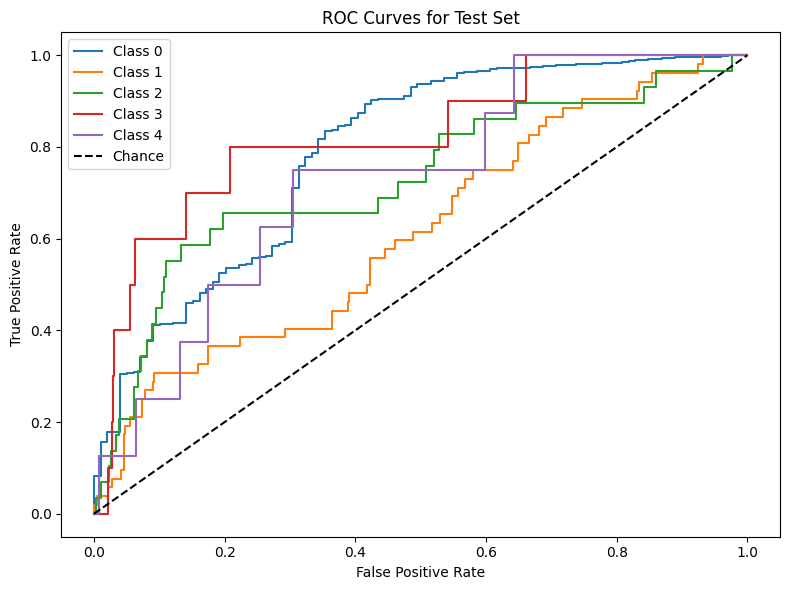

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       395
           1       0.25      0.28      0.26        40
           2       0.17      0.33      0.23        24
           3       1.00      0.10      0.18        10
           4       0.25      0.12      0.17         8

    accuracy                           0.78       477
   macro avg       0.52      0.34      0.35       477
weighted avg       0.82      0.78      0.79       477



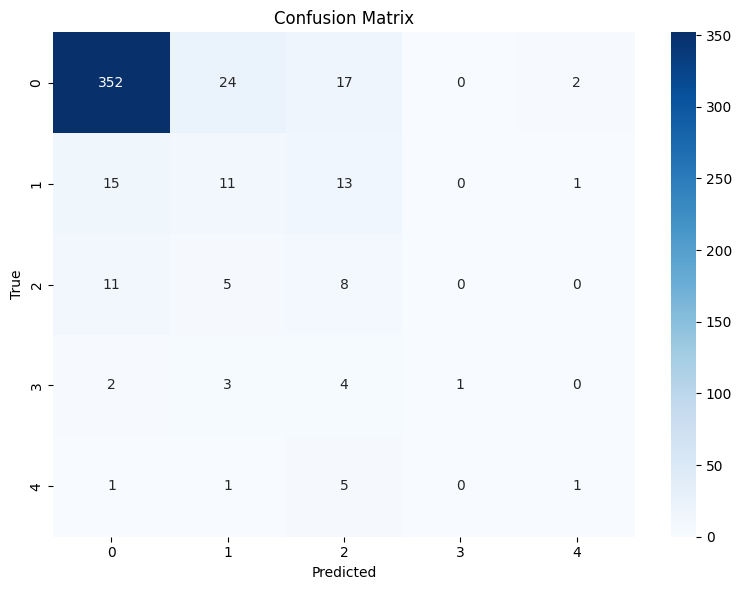


Test AUC (macro-average, OVR): 0.6439


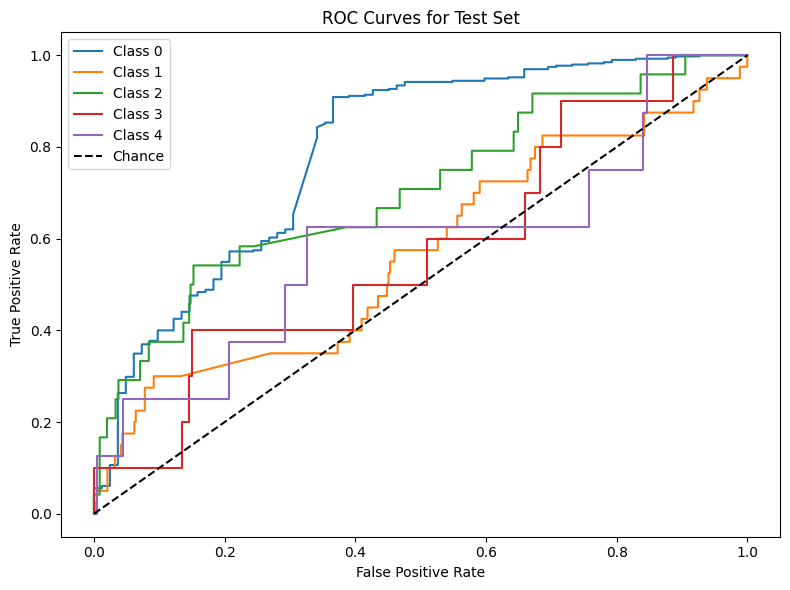

In [13]:
import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
